In [44]:
# author : Florent LUTZ
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.interpolate as inter

In [45]:
# We need to implement a method to compute the atmospheric conditions at any given altitude, this one
# is adapted from FAST

def atmosphere(altitude_ft, delta_t = 0.0):
    
    R_air          = 287.058                                                                # [J/(kg·K)]
    altitude_m     = altitude_ft / 3.28084                                                  # [m]
    
    if altitude_m <= (11000):
        temperature = 288.15 - 0.0065 * ( altitude_m ) + delta_t                            # [K]
        pression    = 101325. * ( 1. - altitude_m / 44330.78 ) ** ( 5.25587611 )            # [Pa]
    
    else:
        temperature = 216.65 + delta_t                                                      # [K]
        pression    = 22632. * ( 2.718281 ) ** ( 1.7345725 - 0.0001576883 * altitude_m )    # [Pa]
      
    density   = pression / (R_air * temperature)                                            # [kg/m3]

    viscosity = ( ( ( 0.00001763 ) * ( temperature / 288.15 ) ** ( 3. / 2. ) ) * \
                  ( ( 288.15 + 110.4 ) / ( temperature + 110.4 ) ) ) / density              # [m2/s]
    
    sos       = math.sqrt( 1.4 * 287 * temperature )                                        # [m/s]

    return temperature, density, pression, viscosity, sos

In [84]:
# Since we want to be able to compare multiple flight domains for multiple aircraft or variations of
# one we want ot create a class that can store all the data required for the computation of the flight
# domain

class Aircraft():
    
    def __init__(self, mtow, wing_area, mgc, Cl_alpha, Cl_max, Cl_max_flaps, Cl_min, Cd_0, k, P_SL, eta_prop, Vh, level, cat, Vh_known = False):

        # Certification
        self.level        = level              # Level of the aircraft according to certifications
        self.category     = cat                # Category of the aircraft, can be 'utility', 'aerobatics', 'normal', 'commuter'
        
        # Mass
        self.mtow         = mtow               # Design Maximum TakeOff Weight [kg] 
  
        # Geometry  
        self.wing_area    = wing_area          # Wing area [m2]
        self.mgc          = mgc                # Mean geometric chord [m]
  
        # Aerodynamics  
        self.Cl_alpha     = Cl_alpha           # Lift coefficient slope [1/rad]
        self.Cl_max       = Cl_max             # Maximum wing lift coefficient [-]
        self.Cl_max_flaps = Cl_max_flaps       # Maximum wing lift coefficient with flaps down [-]
        self.Cl_min       = Cl_min             # Minimum wing lift coefficient [-]
        self.Cd_0         = Cd_0               # Minimum drag coefficient [-]
        self.k            = k                  # Drag polar coefficient [-]
          
        # Propulsion  
        self.P_SL         = P_SL               # Power at sea level [kW]
        self.eta_prop     = eta_prop           # Propeller maximum efficiency [-]
          
        # Performances   
        self.Vh_known     = Vh_known           # Boolean to define if the Vh was already obtained with flight experiments
        self.Vh           = Vh                 # Maximum SL level velocity if already known [kts], value doesn't matter
                                               # if Vh_known is equal to False
        
        # Units conversion 
        self.kts_to_ms    = 0.5144             # Converting from knots to meters per seconds
        self.ft_to_m      = 0.3048             # Converting from feets to meters
        self.lbf_to_N     = 4.4482             # Converting from pound force to Newtons
        
        # Constant definition
        self.g            = 9.81               # Acceleration of gravity [m/s2]
        self.density_SL   = atmosphere(0.)[1]  # Air density at sea level [kg/m3]
        
# In the drawing of the flight domain, it is required to compute the maximum level velocity at sea level
# It can be a data if the flight domain computation is done after the first flight tests, but in the pre-
# design phase it needs to be estimated, hence the following computation. We assume a simple quadratic model
# model for the drag polar. We will use an optimizer to compute this max level speed since there is no
# direct formula for it

    @staticmethod
    def additionnal_power_available(V, mass, self):
        
        # Computing the availbale power with a simple, optimistic model of turboprop/ICE
        available_power = self.P_SL * 1000. * self.eta_prop                                                     # [W]
 
        # Computing the power required for the level flight at a given speed V
        Cl = ( mass * self.g ) / \
             ( 0.5 * self.density_SL * V ** ( 2.0 ) * self.wing_area )                                          # [-]
        Cd = self.Cd_0 + self.k * Cl ** ( 2.0 )                                                                 # [-]
        required_power = 0.5 * self.density_SL * V ** ( 3.0 ) * self.wing_area * Cd                             # [W]
        
        return available_power - required_power

    def maximum_level_velocity(self, mass, Vc):
        
        # Be sure to give Vc in m/s
        initial_speed = Vc                                                                                      # [m/s]
        
        # We use here the fwolve function from scipy optimize, which solve f(x) = 0.0, here since our 
        # function computes the difference between available power and required power, the value which
        # solve the equation will be the maximum level velocity at sea level
        V_max = opt.fsolve(self.additionnal_power_available, initial_speed, args=(mass, self))                  # [m/s]
        Vh = V_max[0]                                                                                           # [m/s]
        
        return Vh
    
    @staticmethod
    def adjust_Cl_alpha(Cl_alpha, mach):
        
        # Simple Prandtl-Glauert correction to account for the compressibility effects of the lift curve slope. Keep in 
        # mind that this correction starts to lose in accuracy for mach number of 0.6 and higher
        
        beta = math.sqrt( 1. - mach ** 2.0 )
        
        Cl_alpha_corr = Cl_alpha / beta
        
        return Cl_alpha_corr
    
    @staticmethod
    def maneuver_load_factor_diff(Va, stall_line_coeff, uncor_gust_coeff, sos, sign, self):
        
        n_Va_stall_line = stall_line_coeff * Va ** 2.0
        mach            = Va * 0.5144 / sos
        
        Cl_alpha_tmp   = 5.0
        # No importance since we only want the corrective factor
        cor_gust_coeff = uncor_gust_coeff * self.adjust_Cl_alpha( Cl_alpha_tmp, mach ) / Cl_alpha_tmp
        
        n_Va_gust_line = 1. + sign * cor_gust_coeff * Va
        
        load_factor_diff = n_Va_stall_line - n_Va_gust_line
        
        return load_factor_diff
    
    def maneuver_velocity(self, stall_line_coeff, uncor_gust_coeff, sos, design_n, sign = 1.):
        
        # Be sure to give Vc in m/s
        initial_speed = math.sqrt( design_n / stall_line_coeff )                                                 # [KEAS]
        
        # We use here the fsolve function from scipy optimize, which solve f(x) = 0.0, here since our 
        # function computes the difference between gust load factor and stall load factor, the value which
        # solve the equation will be the maneuvering speed
        Va_sol = opt.fsolve(self.maneuver_load_factor_diff, initial_speed, 
                           args=(stall_line_coeff, uncor_gust_coeff, sos, sign, self))
        Va = Va_sol[0]                                                                                           # [m/s]
        
        return Va
    
# We now need to implement a method that can compute the limits of the flight domain (maximum and
# minimum load factors/speeds) and return it as a set of data that can then be used to plot different
# flight domains on a single graph. The design VC is in KEAS disregard any other comment that might say
# otherwise

    def flight_domain(self, mass, altitude, design_Vc, design_n_ps = 0.0, design_n_ng = 0.0):
        
        # Preparing here the lists in which we will store the data 
        velocity_array          = []
        load_factor_array       = []
        velocity_array_print    = []
        load_factor_array_print = []
        
        # For some of the correlation presented in the reglementation, we need to convert the data
        # of the airplane to imperial units
        weight_lbf       = (      mass * self.g ) / self.lbf_to_N                                               # [lbf]
        mtow_lbf         = ( self.mtow * self.g ) / self.lbf_to_N                                               # [lbf]
        wing_area_sq_ft  = self.wing_area / ( self.ft_to_m ) ** ( 2. )                                          # [ft2]
        wing_loading_psf = weight_lbf / wing_area_sq_ft                                                         # [lbf/ft2]
        mtow_loading_psf = mtow_lbf  / wing_area_sq_ft                                                          # [lbf/ft2]
        
        # Let's compute the atmospheric constant at the chosen altitude and sea level for Equivalent
        # Air Speeds computation
        sos        = atmosphere(altitude)[4]                                                                    # [m/s]
        density    = atmosphere(altitude)[1]                                                                    # [kg/m3]
        density_SL = self.density_SL                                                                            # [kg/m3]
        
        # We can now start computing the valued of the different airspeeds given in the reglementation
        # as well as the load factors. We will here make the choice to stick with the limits given
        # in the certifications even though they sometimes allow to choose design speeds and loads
        # over the values written in the documents.
        
        # Lets start by computing the 1g stall speeds using the usual formulations
        Vs_1g_ps = math.sqrt( ( 2. * mass * self.g ) / \
                              ( density_SL * self.wing_area *       self.Cl_max   ) ) / self.kts_to_ms          # [KEAS]
        Vs_1g_ng = math.sqrt( ( 2. * mass * self.g ) / \
                              ( density_SL * self.wing_area * abs ( self.Cl_min ) ) ) / self.kts_to_ms          # [KEAS]
        velocity_array.append(Vs_1g_ps)
        velocity_array.append(Vs_1g_ng)
        
        # We will now establish the minimum limit maneuvering load factors outside of gust load 
        # factors. Th designer can take higher load factor if he so wish. As will later be done for the 
        # the cruising speed, we will simply ensure that the designer choice agrees with certifications
        # The limit load factor can be found in section CS 23.337 (a) and (b)
        # https://www.easa.europa.eu/sites/default/files/dfu/CS-23%20Amendment%204.pdf
        # https://www.astm.org/Standards/F3116.htm
        
        if self.category == 'aerobatics':
            n_lim_1      = 6.0                                  # For aerobatic GA aircraft                     # [-]
            
        else:
            n_lim_1      = 3.80                                  # For non aerobatic GA aircraft                # [-]
            
        n_lim_2      = 2.1 + 24000. / ( mtow_lbf + 10000. )  # CS 23.337 (a)                                    # [-]
        n_lim_ps_min = min( n_lim_1, n_lim_2 )               # CS 23.337 (a)                                    # [-]
        n_lim_ps     = max( n_lim_ps_min, design_n_ps )                                                         # [-]
        
        if self.category == 'aerobatics':
            n_lim_ng_max = - 0.5 * n_lim_ps                      # CS 23.337 (b)                                # [-]
            
        else:
            n_lim_ng_max = - 0.4 * n_lim_ps                      # CS 23.337 (b)                                # [-]
            
        n_lim_ng     = min( n_lim_ng_max, design_n_ng )                                                         # [-]
        load_factor_array.append(n_lim_ps)
        load_factor_array.append(n_lim_ng) 
        
        # Starting from there, we need to compute the gust lines as it can have an impact on the choice
        # of the maneuvering speed. We will also compute the maximum intensity gust line for later
        # use but keep in mind that this is specific for commuter or level 4 aircraft
        # The values used to compute the gust lines can be found in CS 23.341
        # https://www.easa.europa.eu/sites/default/files/dfu/CS-23%20Amendment%204.pdf
        
        # We first compute the gust velocities as presented in CS 23.333 (c), for now, we don't take into account
        # the case of the commuter nor do we implement the reduction of gust intensity with the loacation
        # of the gust center 
        
        if altitude < 20000.0:
            U_de_Vc = 50.                                                                                       # [ft/s]
            U_de_Vd = 25.                                                                                       # [ft/s]
            if ( self.level == 4.0 ) or ( self.category == 'commuter' ):
                U_de_Vb = 66.                                                                                   # [ft/s]
            
        elif altitude < 50000.0:
            U_de_Vc = 66.7 - 0.000833 * altitude                                                                # [ft/s]
            U_de_Vd = 33.4 - 0.000417 * altitude                                                                # [ft/s]
            if ( self.level == 4.0 ) or ( self.category == 'commuter' ):
                U_de_Vb = 84.7 - 0.000933 * altitude                                                            # [ft/s]
            
        else:
            U_de_Vc = 25.                                                                                       # [ft/s]
            U_de_Vd = 12.5                                                                                      # [ft/s]
            if ( self.level == 4.0 ) or ( self.category == 'commuter' ):
                U_de_Vb = 38.                                                                                   # [ft/s]
                
        # Here is the aeroplane mass ratio for the particular load case
        mu_g = ( 2. * mass * self.g / self.wing_area ) / \
               ( density * self.mgc * self.Cl_alpha * self.g )                                                  # [-]
        
        # We can now compute the gust alleviation factor
        K_g = ( 0.88 * mu_g ) / ( 5.3 + mu_g )                                                                  # [-]
        
        # Finally, we compute the gust line coefficients
        coef_Vc_gust_line = ( K_g * U_de_Vc * self.Cl_alpha ) / ( 498. * weight_lbf / wing_area_sq_ft )         # [1./KEAS]
        coef_Vd_gust_line = ( K_g * U_de_Vd * self.Cl_alpha ) / ( 498. * weight_lbf / wing_area_sq_ft )         # [1./KEAS]
        
        if ( self.level == 4.0 ) or ( self.category == 'commuter' ):
            coef_Vb_gust_line = ( K_g * U_de_Vb * self.Cl_alpha ) / ( 498. * weight_lbf / wing_area_sq_ft )     # [1./KEAS]
        
        # We can now go back to the computation of the maneuvering speeds, we will first compute it
        # "traditionally" and should we find out that the line limited by the Cl max is under the gust
        # line, we will adjust it (see Step 10. of section 16.4.1 of (1)). As for the traditionnal 
        # computation they can be found in CS 23.335 (c)
        # https://www.easa.europa.eu/sites/default/files/dfu/CS-23%20Amendment%204.pdf
        # https://www.astm.org/Standards/F3116.htm
        
        Va = Vs_1g_ps * math.sqrt(      n_lim_ps   )                                                            # [KEAS]
        Vg = Vs_1g_ng * math.sqrt( abs( n_lim_ng ) )                                                            # [KEAS]
        
        # We now need to check if we are in the aformentionned case (usually happens for low design wing
        # loading aircraft and/or mission wing loading)
        
        Ma = Va / sos
        
        na_gust = 1. + coef_Vc_gust_line * self.adjust_Cl_alpha( self.Cl_alpha, Ma ) / self.Cl_alpha * Va       # [-]
        
        if na_gust > n_lim_ps:
            # In case the gust line load factor is above the maneuvering load factor, we need to solve
            # a polynomial equation to find the new maneuvering speed and load factor
            stall_line_coeff = ( 0.5 * density_SL * 0.5144 ** ( 2.0 ) * self.wing_area * self.Cl_max ) / \
                               ( mass * self.g )
            Va   = self.maneuver_velocity(stall_line_coeff, coef_Vc_gust_line, sos, n_lim_ps)                   # [KEAS]
            n_Va = 1. + coef_Vc_gust_line * Va                                                                  # [-]
            
        else:
            n_Va = n_lim_ps                                                                                     # [-]
        
        velocity_array.append(Va)
        load_factor_array.append(n_Va)
        
        # We now need to do the same thing for the negative maneuvering speed
        
        Mg = Vg / sos
        
        ng_gust = 1. - coef_Vc_gust_line * self.adjust_Cl_alpha( self.Cl_alpha, Ma ) / self.Cl_alpha * Vg       # [-]                                                                   # [-]
        
        if ng_gust < n_lim_ng:
            # In case the gust line load factor is below the maneuvering load factor, we need to solve
            # a polynomial equation to find the new maneuvering speed and load factor
            stall_line_coeff = ( 0.5 * density_SL * 0.5144 ** ( 2.0 ) * self.wing_area * self.Cl_min ) / \
                               ( mass * self.g )

            Vg = self.maneuver_velocity(stall_line_coeff, coef_Vc_gust_line, sos, n_lim_ng, -1)                 # [KEAS]
            n_Vg = 1. - coef_Vc_gust_line * Vg                                                                  # [-]
        
        else:
            n_Vg = n_lim_ng                                                                                     # [-]
            
        velocity_array.append(Vg)
        load_factor_array.append(n_Vg)
        
        # For the cruise velocity, things will be different since it is an entry choice. As such we will
        # simply check that it complies with the values given in the certification papers and reajust
        # it if necessary. For airplane certified for aerobatics, the coefficient in front of the wing
        # loading in psf is slightly different than for normal aircrafts but for either case it becomes
        # 28.6 at wing loading superior to 100 psf
        # Values and methodology used can be found in CS 23.335 (a)
        # https://www.easa.europa.eu/sites/default/files/dfu/CS-23%20Amendment%204.pdf
        # https://www.astm.org/Standards/F3116.htm
        
        if self.category == 'aerobatics':
            if mtow_loading_psf < 20.0:
                k_c = 36.0
            
            elif mtow_loading_psf < 100.:
                # Linear variation from 33.0 to 28.6
                k_c = 36.0 + ( mtow_loading_psf - 20.0 ) * ( 28.6 - 36.0 ) / ( 100.0 - 20.0 ) 
        
            else:    
                k_c = 28.6
            
        else:
            if mtow_loading_psf < 20.0:
                k_c = 33.0

            elif mtow_loading_psf < 100.:
                # Linear variation from 33.0 to 28.6
                k_c = 33.0 + ( mtow_loading_psf - 20.0 ) * ( 28.6 - 33.0 ) / ( 100.0 - 20.0 ) 

            else:    
                k_c = 28.6
            
        Vc_min_1 = k_c * math.sqrt( weight_lbf / wing_area_sq_ft )                                              # [KEAS]
        # This second contraint rather refers to the paragraph on maneuvering speeds, which needs to be chosen 
        # so that they are smaller than cruising speeds
        Vc_min_2 = Va                                                                                           # [KEAS]
        Vc_min   = max( Vc_min_1, Vc_min_2 )                                                                    # [KEAS]

        design_Vc_KEAS = design_Vc                                                                              # [KEAS]
        design_Vc_ms   = design_Vc_KEAS * self.kts_to_ms                                                        # [m/s]
        
        # Depending on whether or not the maximum SL level flight velocity was alreay demonstrated we either 
        # take the value from flight experiments or we compute it using a method which finds for which speed 
        # the power required for flight is equal to the power available
        
        if self.Vh_known:
            Vh = self.Vh                                                                                        # [KEAS]
        
        else:
            Vh = self.maximum_level_velocity( mass, design_Vc_ms ) / self.kts_to_ms                             # [KEAS]
            
        Vc_threshold = 0.9 * Vh                                                                                 # [KEAS]
        
        # The certifications pecifies that Vc need not be more than 0.9 Vh so we will simply take the 
        # minimum value between the Vc_min and this value
        
        Vc_min_fin = min( Vc_min, Vc_threshold )                                                                # [KEAS]
        
        # The constraint regarding the maximum velocity for cruise does not appear in the certifications but 
        # from a physics point of view we can easily infer that the cruise speed will be never be greater than
        # the maximum level velocity at sea level hence
        
        Vc_max = Vh                                                                                             # [KEAS]
        Vc     = design_Vc_KEAS                                                                                 # [KEAS]
        
        if design_Vc_KEAS > Vc_max:
            Vc = Vc_max                                                                                         # [KEAS]
        
        if design_Vc_KEAS < Vc_min_fin:
            Vc = Vc_min_fin                                                                                     # [KEAS]

        velocity_array.append(Vc)

        Mc = Vc * math.sqrt( density_SL / density ) * self.kts_to_ms / sos
        
        # Lets now look at the load factors associated with the Vc, since it is here that the greatest
        # load factors can appear
        
        n_Vc_gust_ps = 1. + coef_Vc_gust_line * self.adjust_Cl_alpha( self.Cl_alpha, Mc ) / self.Cl_alpha * Vc  # [-]
        n_Vc_ps      = max( n_Vc_gust_ps, n_lim_ps )                                                            # [-]
        
        n_Vc_gust_ng = 1. - coef_Vc_gust_line * self.adjust_Cl_alpha( self.Cl_alpha, Mc ) / self.Cl_alpha * Vc  # [-]
        n_Vc_ng      = min( n_Vc_gust_ng, n_lim_ng )                                                            # [-]
        
        load_factor_array.append(n_Vc_ps)
        load_factor_array.append(n_Vc_ng)
        
        # We now compute the diving speed, methods are described in CS 23.335 (b). We will take the minimum 
        # diving speed allowable as our design diving speed. We need to keep in mind that this speed could
        # be greater if the designer was willing to show that the structure holds for the wanted Vd. For 
        # airplane that needs to be certified for aerobatics use, the factor between Vd_min and Vc_min is
        #slightly different, but they both become 1.35 for wing loading higher than 100 psf 
        # https://www.easa.europa.eu/sites/default/files/dfu/CS-23%20Amendment%204.pdf
        # https://www.astm.org/Standards/F3116.htm
        
        Vd_min_1 = 1.25 * Vc                                                                                    # [KEAS]

        if self.category == 'aerobatics':
            if mtow_loading_psf < 20.0:
                k_d = 1.55

            elif mtow_loading_psf < 100.:
                # Linear variation from 1.55 to 1.35
                k_d = 1.55 + ( mtow_loading_psf - 20.0 ) * ( 1.35 - 1.55 ) / ( 100.0 - 20.0 ) 

            else:    
                k_d = 1.35
                
        elif self.category == 'utility':
            if mtow_loading_psf < 20.0:
                k_d = 1.50

            elif mtow_loading_psf < 100.:
                # Linear variation from 1.5 to 1.35
                k_d = 1.50 + ( mtow_loading_psf - 20.0 ) * ( 1.35 - 1.50 ) / ( 100.0 - 20.0 ) 

            else:    
                k_d = 1.35
        
        else:
            if mtow_loading_psf < 20.0:
                k_d = 1.4

            elif mtow_loading_psf < 100.:
                # Linear variation from 1.4 to 1.35
                k_d = 1.4 + ( mtow_loading_psf - 20.0 ) * ( 1.35 - 1.4 ) / ( 100.0 - 20.0 ) 

            else:    
                k_d = 1.35

        Vd_min_2 = k_d * Vc_min_fin                                                                             # [KEAS]
        Vd_min   = max( Vd_min_1, Vd_min_2 )                                                                    # [KEAS]
        
        # There is a third constraint that can come into consideration when selectind the diving speed. It says
        # in CS 23.335 that the two previous conditions need not be proven if the margin between the cruising
        # and diving speed is greater than a certain margin given under the form of a Mach number. Since we have
        # the cruise equivalent airspeed, we will simply convert it back to true airspeed then add the velocity
        # increment in the certification and then take the minimum value between Vd_min and this new constraint.
        # An attempt has been made below but it looks like this section of the certification serves rather as
        # a mean to relax constraints after flight tests were made which means it is out of the scope of this 
        # tool
        
        # Vc_KTAS = Vc * math.sqrt( density_SL / density )                                                      # [KTAS]
        # Vc_ms   = Vc_KTAS * self.kts_to_ms                                                                    # [m/s]
        # 
        # if self.category == 'commuter':
        #     Delta_M = 0.07                                                                                    # [-]
        #     
        # else:
        #     Delta_M = 0.05                                                                                    # [-]
        # 
        # Delta_V = Delta_M * sos                                                                               # [m/s]
        # 
        # Vd_threshold_ms   = Vc_ms + Delta_V                                                                   # [m/s]
        # Vd_threshold_KTAS = Vd_threshold_ms / self.kts_to_ms                                                  # [KTAS]
        # Vd_threshold      = Vd_threshold_KTAS * math.sqrt( density_SL / density )                             # [KEAS]
        # 
        # Vd_tmp = Vd_min
        # 
        # Vd_min = min(Vd_threshold, Vd_tmp)
        
        Vd = Vd_min                                                                                             # [KEAS]
        
        velocity_array.append(Vd)
        
        # Similarly to what was done for the design crusing speed we will explore the load factors
        # associated with the diving speed since gusts are likely to broaden the flight domain around
        # these points 
        
        Md = Vd * math.sqrt( density_SL / density ) * self.kts_to_ms / sos
        
        coef_Vd_gust_line *= self.adjust_Cl_alpha( self.Cl_alpha, Md ) / self.Cl_alpha
        
        n_Vd_gust_ps = 1. + coef_Vd_gust_line * Vd                                                              # [-]
        n_Vd_ps      = max( n_Vd_gust_ps, n_lim_ps )                                                            # [-]
        
        # For the negative load factor at the diving speed, it seems that for non_aerobatic airplanes, it is 
        # always sized according to the gust lines, regardless of the negative design load factor. For aerobatic
        # airplanes however, it seems as if it is sized for a greater value (more negative) but it does not look
        # to be equal to the negative diving factor as can be seen in figure 16-13 of (1). No information was
        # found for the location of this precises point, so the choice was made to take it as the negative
        # design load factor or the load factor given by the gust, whichever is the greatest (most negative).
        # This way, for non aerobatic airplane, we ensure to be conservative.
        
        if ( self.category == 'aerobatics' ):
            n_Vd_gust_ng = 1. - coef_Vd_gust_line * Vd                                                          # [-]
            n_Vd_ng      = min( n_Vd_gust_ng, n_lim_ng )                                                        # [-]
            
        else:
            n_Vd_gust_ng = 1. - coef_Vd_gust_line * Vd                                                          # [-]
            n_Vd_ng      = n_Vd_gust_ng                                                                         # [-]
        
        load_factor_array.append(n_Vd_ps)
        load_factor_array.append(n_Vd_ng)
        
        # We have now calculated all the velocities need to plot the flight domain. For the sake of 
        # thoroughness we will also compute the maximal structural crusing speed and cruise never-exceed 
        # speed. The computation for these two can be found in CS 23.1505
        # https://www.easa.europa.eu/sites/default/files/dfu/CS-23%20Amendment%204.pdf
        # https://www.astm.org/Standards/F3116.htm
        
        # Let us start, as presented in the certifications papers with the never-exceed speed
        # Since we made the choice to take the Vd as the minimum value allowed by certifications, the V_ne
        # will have a fixed value and not a range as one would have expect. Indeed if Vd = Vd_min and since
        # V_ne has to be greater or equal to 0.9 x Vd_min and smaller or equal to 0.9 x Vd, V_ne will be equal
        # to 0.9 Vd. For future implementations, it should be noted that this section will need to be rewritten
        # should the Vd become a design parameter like what was made on Vc. Additionally the effect of
        # buffeting which serves as an additionnal upper limit is not included but should be taken into
        # account in detailled analysis phases
        
        V_ne = 0.9 * Vd                                                                                         # [KEAS]
        
        velocity_array.append(V_ne)
        
        V_no_min = Vc_min                                                                                       # [KEAS]
        V_no_max = min( Vc, 0.89 * V_ne )                                                                       # [KEAS]
        
        # Again we need to make a choice for this speed : what value whould be retained. We will take the 
        # highest speed acceptable for certification, i.e
        
        V_no = V_no_max                                                                                         # [KEAS]
        
        velocity_array.append(V_no)
        
                    
        # One additional velocity needs to be computed if we are talking about commuter aircraft. It is 
        # the maximum gust intensity velocity. Due to the way we are returning the values, even if we are not
        # ivestigating a commuter aircraft we need to return a value for Vb so we will put it to 0.0. If we 
        # are invetigating a commuter aircraft, we will compute it according ot the guidleines from CS 23.335 (d)
        # https://www.easa.europa.eu/sites/default/files/dfu/CS-23%20Amendment%204.pdf
        # https://www.astm.org/Standards/F3116.htm
        # We decided to put this computation here as we may need the gust load factor in cruise conditions for
        # one of the possible candidates for the Vb. While writing this program, the writer realized they were 
        # no paragraph that impeach the Vc from being at a value such that one one of the conditions for the
        # minimum speed was above the Vc creating a problem with point (2). This case may however never appear
        # in practice as it would suppose that the Vc chosen is above the stall line which is more than certainly
        # avoided by the correlation between Vc_min and W/S in CS 23.335 (a)
        
        if ( self.level == 4.0 ) or ( self.category == 'commuter' ):
            
            # We first need to compute the intersection of the stall line with the gust line given by the 
            # gust of maximum intensity. Similar calculation were already done in case the maneuvering speed
            # is dictated by the Vc gust line so the computation will be very similar
            
            n_Vc_gust = 1. + coef_Vc_gust_line * self.adjust_Cl_alpha( self.Cl_alpha, Mc ) / self.Cl_alpha * Vc # [-]
            
            coeff_stall_line = ( 0.5 * density_SL * 0.5144 ** ( 2.0 ) * self.wing_area * self.Cl_max ) / \
                  ( mass * self.g )
            Vb_min_1 = self.maneuver_velocity(coeff_stall_line, coef_Vb_gust_line, sos, n_Vc_gust)
            
            # The second candidate for the Vb is given by the stall speed and the load factor at the cruise 
            # speed
            
            Vb_min_2  = Vs_1g_ps * math.sqrt( n_Vc_gust )                                                       # [KEAS]
            Vb        = min( Vb_min_1, Vb_min_2 )                                                               # [KEAS]

            # As for the computation of the associated load factor, no source were found for any formula or
            # hint as to its computation. It can however be guessed that depending on the minimum value found
            # above, it will either be on the stall line or at the maximum design load factor
            
            if ( Vb == Vb_min_1 ) : # On the gust line
                n_Vb = ( 0.5 * self.density_SL * self.wing_area * self.Cl_max ) / ( mass * self.g ) * \
                       ( Vb ** ( 2.0 ) * self.kts_to_ms ** ( 2.0 ) )                                            # [-]
            
            else:
                n_Vb = n_Vc_ps                                                                                 # [-]
            
        else:
            Vb = 0.0                                                                                            # [KEAS]
            n_Vb = 0.0
        
        velocity_array.append(Vb)
        load_factor_array.append(n_Vb)
        
        # Let us now look at the flight domain in the flap extended configuration. For the computation of these
        # speeds and load factos, we will use the formula provided in CS 23.1511
        # https://www.easa.europa.eu/sites/default/files/dfu/CS-23%20Amendment%204.pdf
        # https://www.astm.org/Standards/F3116.htm
        
        # For the computation of the Vfe CS 23.1511, refers to CS 23.345 but there only seems to be a 
        # requirement for the lowest the Vfe can be, hence we will take this speed as the Vfe. As for the 
        # load factors that are prescribed we will use the guidlines provided in CS 23.345 (b)
        
        # Let us start by computing the Vfe
        Vsfe_1g_ps = math.sqrt( ( 2. * mass * self.g ) / \
                                ( density_SL * self.wing_area * self.Cl_max_flaps ) ) / self.kts_to_ms           # [KEAS] 
        Vfe_min_1  = 1.4 * Vs_1g_ps                                                                              # [KEAS]
        Vfe_min_2  = 1.8 * Vsfe_1g_ps                                                                            # [KEAS]
        Vfe_min   = max( Vfe_min_1, Vfe_min_2 )                                                                  # [KEAS]
        Vfe       = Vfe_min                                                                                      # [KEAS]
        
        velocity_array.append(Vsfe_1g_ps)  
        velocity_array.append(Vfe)
        
        # We can then move on to the computation of the load limitation of the flapped flight domain, which
        # must be equal to either a constant load factor of 2 or a load factor dictated by a gust of 25 fps.
        # Also since the use of flaps is limited to take-off, approach and landing, we will use the SL density
        # and a constant gust velocity 
        
        U_de_fe = 25.                                                                                           # [ft/s]
        
        # Here is the aeroplane mass ratio for the particular load case
        mu_g = ( 2. * mass * self.g / self.wing_area ) / \
               ( density * self.mgc * self.Cl_alpha * self.g )                                                  # [-]
        
        # We can now compute the gust alleviation factor
        K_g = ( 0.88 * mu_g ) / ( 5.3 + mu_g )                                                                  # [-]
        
        # Finally, we compute the gust line coefficients
        coef_Vfe_gust_line = ( K_g * U_de_fe * self.Cl_alpha ) / ( 498. * weight_lbf / wing_area_sq_ft )        # [1./KEAS]
        
        n_lim_ps_fe = 2.0
        
        n_Vfe_max_1 = n_lim_ps_fe
        n_Vfe_max_2 = 1. + coef_Vfe_gust_line * Vfe
        n_Vfe       = max( n_Vfe_max_1, n_Vfe_max_2 ) 
        
        load_factor_array.append(n_Vfe)
        
        # We also store the conditions in which the values were computed so that we can easily access
        # them when drawing the flight domains
        
        conditions = [ mass, altitude ]
        
        return velocity_array, load_factor_array, conditions

# We now have a method that can compute all the different velocities and load factors required to
# plot the flight domain. The careful reader notices that the flaps extended flight domain and 
# associated velocities were not computed as of now, it may come as an addition in future version
# of the Notebook. For now we will focus on the drawing of the flight domain

    def plot_combined_flight_domain(self, velocity_array, load_factor_array, conditions, figure_number, fill = False, flaps = False, flaps_fill = False):
        
        # Lets us first decompress all the information contained in the inputs, with the 
        # velocities first ...
        Vs_1g_ps   = velocity_array[0]                                                                          # [KEAS]
        Vs_1g_ng   = velocity_array[1]                                                                          # [KEAS]
        Va         = velocity_array[2]                                                                          # [KEAS]
        Vg         = velocity_array[3]                                                                          # [KEAS]
        Vc         = velocity_array[4]                                                                          # [KEAS]
        Vd         = velocity_array[5]                                                                          # [KEAS]
        V_ne       = velocity_array[6]                                                                          # [KEAS]
        V_no       = velocity_array[7]                                                                          # [KEAS]
        Vb         = velocity_array[8]                                                                          # [KEAS]
        Vsfe_1g_ps = velocity_array[9]                                                                          # [KEAS]
        Vfe        = velocity_array[10]                                                                         # [KEAS]
        
        # ... and then the load factors ...
        n_lim_ps = load_factor_array[0]                                                                         # [-]
        n_lim_ng = load_factor_array[1]                                                                         # [-]
        n_Va     = load_factor_array[2]                                                                         # [-]
        n_Vg     = load_factor_array[3]                                                                         # [-]
        n_Vc_ps  = load_factor_array[4]                                                                         # [-]
        n_Vc_ng  = load_factor_array[5]                                                                         # [-]
        n_Vd_ps  = load_factor_array[6]                                                                         # [-]
        n_Vd_ng  = load_factor_array[7]                                                                         # [-]
        n_Vb     = load_factor_array[8]                                                                         # [-]
        n_Vfe    = load_factor_array[9]                                                                         # [-]
        
        # ... and finally the conditions.
        mass     = conditions[0]                                                                                # [kg]
        altitude = conditions[1]                                                                                # [ft]
        
        # To differentiate the different figure we give them different colors and markers. The choice is
        # arbitrarily made by the author and can be changed by anyone Python-savy enough.
        
        if figure_number == 1.:
            color_name    = 'black'
            marker_style  = 'o'
            marker_legend = 'o-'
            label_legend  = 'Aircraft 1'
        elif figure_number == 2.:
            color_name    = 'blue'
            marker_style  = 's'
            marker_legend = 's-'
            label_legend  = 'Aircraft 2'
        elif figure_number == 3.:
            color_name    = 'red'
            marker_style  = 'd'
            marker_legend = 'd-'
            label_legend  = 'Aircraft 3'
        elif figure_number == 4.:
            color_name    = 'green'
            marker_style  = 'x'
            marker_legend = 'x-'
            label_legend  = 'Aircraft 4'
        else:
            color_name    = 'orchid'
            marker_style  = 'v'
            marker_legend = 'v-'
            label_legend  = 'Aircraft 5'
            
        point_size = 2.5
        
        # Preparing the arrays needed to fill out the fligh domain
        if fill:
            fill_line_ps_x = []
            fill_line_ps_y = []
            
            fill_line_ng_x = []
            fill_line_ng_y = []
            
        # We can now start plotting the different parts of the graphs, it is planned that the creation
        # of the figure will be done before even calling these functions and that the labels and titles
        # will be done after calling these functions. As such we will only see plots, scatter_plot and
        # fill_between call. The choice is left up to the operator to turn off the fill_between calls
        # with an entry choice as plotting two many flight domain at once will result in an "artistic" but
        # nonetheless unreadable plot. The author made the choice to not plot the values of the different point
        # as they can easily be accessed through the result of the flight_domain function to avoid over encumbering the
        # plot
        
        # Before anything we re-compute the coefficients of the gust lines as they will later be needed
        # when computing intersections on the graph or simply when we will want to plot them 
        
        if altitude < 20000.0:
            U_de_Vc = 50.                                                                                       # [ft/s]
            U_de_Vd = 25.                                                                                       # [ft/s]
            if ( self.level == 4.0 ) or ( self.category == 'commuter' ):
                U_de_Vb = 66.                                                                                   # [ft/s]
            
        elif altitude < 50000.0:
            U_de_Vc = 66.7 - 0.000833 * altitude                                                                # [ft/s]
            U_de_Vd = 33.4 - 0.000417 * altitude                                                                # [ft/s]
            if ( self.level == 4.0 ) or ( self.category == 'commuter' ):
                U_de_Vb = 84.7 - 0.000933 * altitude                                                            # [ft/s]
            
        else:
            U_de_Vc = 25.                                                                                       # [ft/s]
            U_de_Vd = 12.5                                                                                      # [ft/s]
            if ( self.level == 4.0 ) or ( self.category == 'commuter' ):
                U_de_Vb = 38.                                                                                   # [ft/s]
        
        U_de_fe = 25.                                                                                           # [ft/s]
        
        density_SL = self.density_SL
        density = atmosphere(altitude)[1]
        sos     = atmosphere(altitude)[4]
        mu_g    = ( 2. * mass * self.g / self.wing_area ) / ( density * self.mgc * self.Cl_alpha * self.g )     # [-]
        K_g     = ( 0.88 * mu_g ) / ( 5.3 + mu_g )                                                              # [-]
        
        Mc      = Vc * self.kts_to_ms * math.sqrt( density_SL / density ) / sos
        Md      = Vd * self.kts_to_ms * math.sqrt( density_SL / density ) / sos
        Mb      = Vb * self.kts_to_ms * math.sqrt( density_SL / density ) / sos
        
        coef_Vc  = ( K_g * U_de_Vc * self.adjust_Cl_alpha( self.Cl_alpha, Mc ) ) / \
                   ( ( 498. * mass * self.g / self.lbf_to_N ) / ( self.wing_area / self.ft_to_m ** ( 2.0 ) ) )  # [1./KEAS]
        coef_Vd  = ( K_g * U_de_Vd * self.adjust_Cl_alpha( self.Cl_alpha, Md ) ) / \
                   ( ( 498. * mass * self.g / self.lbf_to_N ) / ( self.wing_area / self.ft_to_m ** ( 2.0 ) ) )  # [1./KEAS]
        coef_Vfe = ( K_g * U_de_fe * self.Cl_alpha ) / \
                   ( ( 498. * mass * self.g / self.lbf_to_N ) / ( self.wing_area / self.ft_to_m ** ( 2.0 ) ) )  # [1./KEAS]
        
        if ( self.level == 4.0 ) or ( self.category == 'commuter' ):
                 coef_Vb = ( K_g * U_de_Vb * self.adjust_Cl_alpha( self.Cl_alpha, Mb ) ) / \
                           ( ( 498. * mass * self.g / self.lbf_to_N ) / \
                             ( self.wing_area / self.ft_to_m ** ( 2.0 ) ) )                                     # [1./KEAS]    
        
        # Plotting the start of the graph which is the line at Vs
        
        plt.plot([Vs_1g_ps, Vs_1g_ps],[0.0, 1.0], color = color_name)
        plt.scatter(Vs_1g_ps, 1.0, marker = marker_style, linewidth = point_size, color = color_name)
        
        # We now compute and plot the stall_line
        stall_line_V_ps = np.linspace(Vs_1g_ps, Va, 100)                                                        # [KEAS]
        stall_line_n_ps = ( 0.5 * self.density_SL * self.wing_area * self.Cl_max ) / ( mass * self.g ) * \
                          ( stall_line_V_ps ** ( 2.0 ) * self.kts_to_ms ** ( 2.0 ) )                            # [-]
        plt.plot(stall_line_V_ps, stall_line_n_ps, color = color_name)
        plt.scatter(Va, n_Va, marker = marker_style, linewidth = point_size, color = color_name)
        
        if fill:
            fill_line_ps_x = np.concatenate((fill_line_ps_x, stall_line_V_ps))
            fill_line_ps_y = np.concatenate((fill_line_ps_y, stall_line_n_ps))
        
        # We will now plot the line that goes from point A to point C, there are multiple cases that can
        # appears for this line, and depending on the relative value of the load factors in A and C and the
        # airplane category, a different plotting stategy needs to be used
        
        if ( self.category == 'commuter' ) or ( self.level == 4.0 ):
            
            # For the commuter category, to go from A to C we must first make a halt at point B. It location
            # will depend on which of the constraints was retained for the computation of Vb and the associated
            # load factor. In every case though, it will be located on the stall line (it just might not be at
            # the intersection of the max intesity gust line), and then we will simply make a straight link to 
            # point C
            
            # From A to B
            
            stall_line_V_max_gust = np.linspace(Va, Vb, 50)                                                     # [KEAS]
            stall_line_n_max_gust = ( 0.5 * self.density_SL * self.wing_area * self.Cl_max ) / \
                                    ( mass * self.g ) * \
                                    ( stall_line_V_max_gust ** ( 2.0 ) * self.kts_to_ms ** ( 2.0 ) )            # [-]
            
            plt.plot(stall_line_V_max_gust, stall_line_n_max_gust, color = color_name)
            plt.scatter(Vb, n_Vb, marker = marker_style, linewidth = point_size, color = color_name)
            
            if fill:
                fill_line_ps_x = np.concatenate((fill_line_ps_x, stall_line_V_max_gust[1:-1]))
                fill_line_ps_y = np.concatenate((fill_line_ps_y, stall_line_n_max_gust[1:-1]))
            
            # From B to C
            
            plt.plot([Vb, Vc], [n_Vb, n_Vc_ps], color = color_name)
            plt.scatter(Vc, n_Vc_ps, marker = marker_style, linewidth = point_size, color = color_name)
            
            if fill:
                fill_line_ps_x = np.concatenate((fill_line_ps_x, [Vc]))
                fill_line_ps_y = np.concatenate((fill_line_ps_y, [n_Vc_ps]))
        
        else:
            
            # Three different case for the segment that goes from point A to point C for non commuter airplane :
            # - the first case is if the maneuvering speed/ load factor is moved due to the presence of gusts
            # we need to plot a straight line from A to C as presented in the first graph of figure 16-13 of
            # (1)
            
            if n_Va > n_lim_ps:
                plt.plot([Va, Vc],[n_Va, n_Vc_ps], color = color_name)
                
                if fill:
                    fill_line_ps_x = np.concatenate((fill_line_ps_x, [Vc]))
                    fill_line_ps_y = np.concatenate((fill_line_ps_y, [n_Vc_ps]))
    
                plt.scatter(Vc, n_Vc_ps, marker = marker_style, linewidth = point_size, color = color_name)
            
            # - the second case is when point A is not size for the gust but point C is sized by the gust lines
            # it usually happens for typical wing loading and is presented in the second graph from figure  16-13 of
            # (1)
            
            elif n_Vc_ps > n_lim_ps:
                
                # We first need to reconstruct the gust line as the informations were not carried out from
                # the computation of the velocities. Since it is a simple linear curve, a linear variation
                # will give the exact result. We wil then find the intersection of the gust line with the
                # horizontal curve corresponding to n_lim_ps and join the two points via the semilines
                
                V_intersec = ( n_lim_ps - 1. ) / coef_Vc                                                        # [KEAS]
    
                plt.plot([Va, V_intersec],[n_Va, n_lim_ps], color = color_name)
                plt.plot([V_intersec, Vc],[n_lim_ps, n_Vc_ps], color = color_name)
                
                if fill:
                    fill_line_ps_x = np.concatenate((fill_line_ps_x, [V_intersec, Vc]))
                    fill_line_ps_y = np.concatenate((fill_line_ps_y, [n_lim_ps, n_Vc_ps]))
    
                plt.scatter(Vc, n_Vc_ps, marker = marker_style, linewidth = point_size, color = color_name)
            
            # - the third and last case for this segment is if the gust line is under the positive load factor
            # at the cruising speed, in this case there is no point C but we will put a virtual point C for the
            # drawing of the line
            
            else:
                plt.plot([Va, Vc],[n_Va, n_lim_ps], color = color_name)
                
                if fill:
                    fill_line_ps_x = np.concatenate((fill_line_ps_x, [Vc]))
                    fill_line_ps_y = np.concatenate((fill_line_ps_y, [n_lim_ps]))

        # We will now plot the line going from C to D. Then again, there are multiples ways to draw it
        # depending on the relative positionning of point C, point D and the limit load factor line.
        
        # Three different case have been identified base on the drawing presented in figure 16-13 of (1) :
        # - the first case is when point D is located above the positive limit load factor because of the
        # gust line. In this case we go straight from C to D as presented in the first graph of figure 16-13 
        # of (1)
        
        if n_Vd_ps > n_lim_ps:
            plt.plot([Vc, Vd],[n_Vc_ps, n_Vd_ps], color = color_name)
            
            if fill:
                fill_line_ps_x = np.concatenate((fill_line_ps_x, [Vd]))
                fill_line_ps_y = np.concatenate((fill_line_ps_y, [n_Vd_ps]))

            plt.scatter(Vd, n_Vd_ps, marker = marker_style, linewidth = point_size, color = color_name)
        
        # - the second case is when point D is under the positive limit load factor but when point C is 
        # above it, which corresponds to the second graph of figure 16-13 of (1)  
        
        elif n_Vc_ps > n_lim_ps:

            # We need to find the intersection between the line going from point C to the intersection of 
            # the vertical Vd line and the Vd gust and the horizontal line at the postitive limit load factor. 
            # Then again, it is a line so a linear fit will give the exact result. From the analytical 
            # expression, we know that coef_Vd is equal  to half of coef_Vc thus, since the coefficient in 
            # front of the Vin the gust line expression dependslinearly on the gust speeds for which we find, 
            # regardless of altitude, U_Vd = 1/2 x U_Vc
            
            n_Vd_fict = 1.0 + coef_Vd * Vd                                                                      # [-]
            V_int     = Vc + ( Vd - Vc ) * ( n_lim_ps - n_Vc_ps ) / ( n_Vd_fict - n_Vc_ps )                     # [KEAS]

            plt.plot([Vc, V_int], [n_Vc_ps, n_lim_ps], color = color_name)
            plt.plot([V_int, Vd], [n_lim_ps, n_Vd_ps], color = color_name)

            if fill:
                fill_line_ps_x = np.concatenate((fill_line_ps_x, [V_int, Vd]))
                fill_line_ps_y = np.concatenate((fill_line_ps_y, [n_lim_ps, n_Vd_ps]))
            
            plt.scatter(Vd, n_Vd_ps, marker = marker_style, linewidth = point_size, color = color_name)
        
        # - the third and last case is when both point C and point D are under the positive limit load line, in 
        # this case, we simply draw a straight line goind from the fictive point C of the precedent step to the 
        # point D. This case is shown in the third graph of figure 16-13 of (1) 
        
        else:
            plt.plot([Vc, Vd],[n_Vd_ps, n_Vd_ps], color = color_name)
            
            if fill:
                fill_line_ps_x = np.concatenate((fill_line_ps_x, [Vd]))
                fill_line_ps_y = np.concatenate((fill_line_ps_y, [n_Vd_ps]))

            plt.scatter(Vd, n_lim_ps, marker = marker_style, linewidth = point_size, color = color_name)
                
        # To end with the part of the graph regarding the positive load factor we cimply close off the right part of 
        # the graph with a vertical line. 
        
        plt.plot([Vd, Vd],[n_Vd_ps, 0.0], color = color_name)
                
        # Now we will start working on the lower part of the flight domain. Just like for the top part of the domain 
        # we will start from the stall speed and make our way up to the diving speed with, for each several powwible
        # choice on how to loink two points of the graph.
        
        # Starting with the straight line going from 0.0 to -1.0 at the negative stall speed
        plt.plot([Vs_1g_ng, Vs_1g_ng],[0.0, -1.0], color = color_name)
        plt.scatter(Vs_1g_ng, -1.0, marker = marker_style, linewidth = point_size, color = color_name)
        
        # We now compute and plot the negative stall_line
        stall_line_V_ng = np.linspace(Vs_1g_ng, Vg, 100)                                                        # [KEAS]
        stall_line_n_ng = - ( 0.5 * self.density_SL * self.wing_area * abs ( self.Cl_min ) ) / \
                            ( mass * self.g ) * \
                            ( stall_line_V_ng ** ( 2.0 ) * self.kts_to_ms ** ( 2.0 ) )                          # [-]
        plt.plot(stall_line_V_ng, stall_line_n_ng, color = color_name)
        plt.scatter(Vg, n_Vg, marker = marker_style, linewidth = point_size, color = color_name)
        
        if fill:
            fill_line_ng_x = np.concatenate((fill_line_ng_x, stall_line_V_ng))
            fill_line_ng_y = np.concatenate((fill_line_ng_y, stall_line_n_ng))
        
        # Now that this is done we need to go from point G to point F. Two cases are identified in the Gudmundsson but the author
        # thinks that a third one should be envisionned. The two cases presented in Gudmunsson are distinguished by the value of n_Vf
        # compared to n_lim_ng. In both case n_Vg is equal to n_lim_ng and the case where n_Vg is sized based on gust is not presented.
        # The the conditions to have this case may be rare, extremely small wing loading or strong gust, the case is still implemented
        # for the sake of thoroughness and since it is pretty much coded with the postive gust line. So :
        
        # Three different case for the segment that goes from point G to point F :
        # - the first case is if the maneuvering speed/ load factor is moved due to the presence of gusts
        # we need to plot a straight line from G to F as is done in the similar case for the positive gust line
        
        if n_Vg < n_lim_ng:
            plt.plot([Vg, Vc],[n_Vg, n_Vc_ng], color = color_name)
            
            if fill:
                fill_line_ng_x = np.concatenate((fill_line_ng_x, [Vc]))
                fill_line_ng_y = np.concatenate((fill_line_ng_y, [n_Vc_ng]))

            plt.scatter(Vc, n_Vc_ng, marker = marker_style, linewidth = point_size, color = color_name)
        
        # - the second case is when point G is not sized for the gust but point F is sized by the gust lines
        # it usually happens for low wing loading and is presented in the first graph from figure  16-13 of
        # (1)
        
        elif n_Vc_ng < n_lim_ng:
            
            # We first need to reconstruct the gust line as the informations were not carried out from
            # the computation of the velocities. Since it is a simple linear curve, a linear variation
            # will give the exact result. We wil then find the intersection of the gust line with the
            # horizontal curve corresponding to n_lim_ng and join the two points via the semilines
            
            V_intersec = ( n_lim_ng - 1. ) / ( - coef_Vc )                                                      # [KEAS]

            plt.plot([Vg, V_intersec],[n_Vg, n_lim_ng], color = color_name)
            plt.plot([V_intersec, Vc],[n_lim_ng, n_Vc_ng], color = color_name)
            
            if fill:
                fill_line_ng_x = np.concatenate((fill_line_ng_x, [V_intersec, Vc]))
                fill_line_ng_y = np.concatenate((fill_line_ng_y, [n_lim_ng, n_Vc_ng]))

            plt.scatter(Vc, n_Vc_ng, marker = marker_style, linewidth = point_size, color = color_name)
        
        # - the third and last case for this segment is if the gust line is over the negative load factor
        # at the cruising speed, in this case there is no point F but we will put a virtual point F for the
        # drawing of the line and an eventual intersection computation in the next part of the drawing
        
        else:
            plt.plot([Vg, Vc],[n_Vg, n_lim_ng], color = color_name)
            
            if fill:
                fill_line_ng_x = np.concatenate((fill_line_ng_x, [Vc]))
                fill_line_ng_y = np.concatenate((fill_line_ng_y, [n_lim_ng]))
                
            plt.scatter(Vc, n_Vc_ng, marker = marker_style, linewidth = point_size, color = color_name)
        
        # As for the exemple of the segment going from A to C which different depending on the type of the aircraft, 
        # the segment going from F to E is different for aerobatics aircraft and non aerobatics aircraft
        
        if self.category == 'aerobatics':
            
            # Three scenarii appears in front of us depending on the position of point E.
            
            # The first scenario is when E is sized according to a gust line. Then point F will also be sized for gust
            # since n_Vd_ng < n_lim_ng ==> n_Vc_ng < n_lim_ng because the gust line at F is sharper, in this case we 
            # can simply link the two 
            
            if n_Vd_ng < n_lim_ng: 
                plt.plot([Vc, Vd],[n_Vc_ng, n_Vd_ng], color = color_name)
                
                if fill:
                    fill_line_ng_x = np.concatenate((fill_line_ng_x, [Vd]))
                    fill_line_ng_y = np.concatenate((fill_line_ng_y, [n_Vd_ng]))
    
                plt.scatter(Vd, n_Vd_ng, marker = marker_style, linewidth = point_size, color = color_name)
        
            # The second scenario is when E is not sized for the gust line but F is. In this case we will simply follow
            # the negative design load factor until we cross the line going from point F to the point (Vd, O.) as is done for
            # non aerobatics airplane
            
            elif n_Vc_ng < n_lim_ng:
                
                x_a1 = Vc
                y_a1 = n_Vc_ng
                
                x_a2 = Vd
                y_a2 = 0.0
                
                c_a = ( y_a1 - y_a2 ) / ( x_a1 - x_a2 )
                d_a = y_a1 - c_a * x_a1
                
                V_int = ( n_lim_ng - d_a ) / c_a
                
                # We can now carry on with the plot
                
                plt.plot([Vc, V_int],[n_Vc_ng, n_lim_ng], color = color_name)
                plt.plot([V_int, Vd],[n_lim_ng, n_Vd_ng], color = color_name)
                
                if fill:
                    fill_line_ng_x = np.concatenate((fill_line_ng_x, [V_int, Vd]))
                    fill_line_ng_y = np.concatenate((fill_line_ng_y, [n_lim_ng, n_Vd_ng]))
    
                plt.scatter(Vd, n_Vd_ng, marker = marker_style, linewidth = point_size, color = color_name)
            
            # Last case is when they are both on the negative design load factor and we simply link the two
            
            else:
                plt.plot([Vc, Vd],[n_Vc_ng, n_Vd_ng], color = color_name)
                
                if fill:
                    fill_line_ng_x = np.concatenate((fill_line_ng_x, [Vd]))
                    fill_line_ng_y = np.concatenate((fill_line_ng_y, [n_Vd_ng]))
    
                plt.scatter(Vd, n_Vd_ng, marker = marker_style, linewidth = point_size, color = color_name)
        
        else:    
        
            # Finally we must draw the segment going from F to E. Then again, only two case are identified for this segment
            # in the figure 16-13 of (1), but one case is not represented ( n_Vc_ng < n_lim_ng and n_Vd_ng < n_lim_ng ). This 
            # prompts us to elaborate a strategy. We can either try to find an intersection like for the two last graphs of the 
            # first line of figure 16-13 or we could simply draw a straight line from point E to point F like the first graph of figure
            # 16-13. The author opted to go for the latter solution for two reasons. The first is that it would be more constraining
            # in terms of flight enveloppe (wider enveloppe) and thus an misinterpretation could only mean a good surprise. The second 
            # reason would be that the three case would become two and only depend on the value of n_Vc_ng compared to n_lim_ng. So :
            
            # Two different case for going from E to F : 
            # - the first one is if n_Vc_ng < n_lim_ng. In this case we are in a similar situation as the first domain of figure 16-13
            # and the case explained above. We thus draw a straight line going from F to E
            
            if n_Vc_ng < n_lim_ng:
                plt.plot([Vc, Vd],[n_Vc_ng, n_Vd_ng], color = color_name)
                
                if fill:
                    fill_line_ng_x = np.concatenate((fill_line_ng_x, [Vd]))
                    fill_line_ng_y = np.concatenate((fill_line_ng_y, [n_Vd_ng]))
    
                plt.scatter(Vd, n_Vd_ng, marker = marker_style, linewidth = point_size, color = color_name)
            
            # - the second case where n_Vc_ng = n_lim_ng, here we need to find the intersection between (a) the line that goes from
            # the point (Vc, n_lim_ng) to the point (Vd, 0.0) and (b) the line that goes from the point of intersection from the 
            # negative Vc gust line and the vertival line at Vc and the point of intersection from the negative Vd gust line and 
            # the vertival line at Vd
            
            else:
                
                # Let us first start by listing the coordinates mentionned in the paragraph above. For the sake of clarity the first
                # line mentionned will be line (a) with point a1 and a2 and the second will be line b with point b1 and b2. Since we need 
                # the gust lines, let's also recompute the coefficients. However this time we cannot access them easily through existing
                # point since in this case the point is not sized for gust and thus it was overwritten by other conditions. We shall
                # thus quicly recompute it. Explanations can be found in the function flight_domain
                
                x_a1 = Vc
                y_a1 = n_lim_ng
                
                x_a2 = Vd
                y_a2 = 0.0
                
                x_b1 = Vc
                y_b1 = 1. - coef_Vc * Vc
    
                x_b2 = Vd
                y_b2 = 1. - coef_Vd * Vd
    
                # Let's now reconstruct those line under the form n = c x V + d, with the right subscript for each line : c_a, d_a and
                # c_b, d_b
                
                c_a = ( y_a1 - y_a2 ) / ( x_a1 - x_a2 )
                c_b = ( y_b1 - y_b2 ) / ( x_b1 - x_b2 )
    
                d_a = y_a1 - c_a * x_a1
                d_b = y_b1 - c_b * x_b1
    
                # We now we can compute the x- and y-coordinate of the point of intersection using the common formula for the intersection
                # of two lines which gives us the following formulae. THis may have been clumsy from the author but this intersecion will
                # bear the subscript V_int which might be confused with the V_intersec presented in the top part of the diagram. Even though
                # this has strictly no impact on the outcome of the code the reader should be careful. 
                
                V_int = - ( d_a - d_b ) / ( c_a - c_b )                                                             # [KEAS]
                n_int = c_a * V_int + d_a                                                                           # [-]
                
                # We can now carry on with the plot
                
                plt.plot([Vc, V_int],[n_Vc_ng, n_int], color = color_name)
                plt.plot([V_int, Vd],[n_int, n_Vd_ng], color = color_name)
                
                if fill:
                    fill_line_ng_x = np.concatenate((fill_line_ng_x, [V_int, Vd]))
                    fill_line_ng_y = np.concatenate((fill_line_ng_y, [n_int, n_Vd_ng]))
    
                plt.scatter(Vd, n_Vd_ng, marker = marker_style, linewidth = point_size, color = color_name)
        
        # We now simply need to close off the graph like we did in the top part and close off the graph between the postive and negative
        # stall speeds
        
        plt.plot([Vd, Vd],[n_Vd_ng, 0.0], color = color_name)
        plt.plot([Vs_1g_ps, Vs_1g_ng],[0.0, 0.0], marker_legend, color = color_name, label = label_legend)
        
        if fill:                
            plt.fill_between(fill_line_ps_x, fill_line_ps_y, color = color_name, alpha=0.15, edgecolor = 'none', linewidth = 0.0)
            plt.fill_between(fill_line_ng_x, fill_line_ng_y, color = color_name, alpha=0.15, edgecolor = 'none', linewidth = 0.0) 
        
        # Now we can do the same for the flight domain with flaps extended for which the plotting procedure is
        # the same albeit much smaller. The author has not found books or paper that treats the particular topic
        # of the flaps extended flaps domain, so the drawing (and the hypothesis taken), will be based on the 
        # interpretation of the regulations and for cases similar to the clean flight domain, the same procedure
        # will be applied
        
        if flaps:
            
            fill_line_fe_x = []
            fill_line_fe_y = []
            
            # Let's start of by plotting the vertical line at the 1g stall speed.
            
            plt.plot([Vsfe_1g_ps, Vsfe_1g_ps],[0.0, 1.0], color = color_name, linestyle = '-.')
            plt.scatter(Vsfe_1g_ps, 1.0, marker = marker_style, linewidth = point_size, color = color_name)
            
            # The point that is located at the top of the stall line (point A for the clean flight domain) does
            # not seem to be used in ceritification but it is of use in our case as it is a reference point for
            # drawing the stall line, we will compute him as if it was point A for the clean flight domain but
            # we will adjust the load factors and check if he is above or below the 25 fps gust line as we did 
            # for the clean flight domain. We will call this point, point A_fe
            
            # The following formula is used for the computation of point A_fe, similarly to the formula used
            # for Va except that this time the flaps extended design load factor is considered to be 2. as can 
            # be infered from CS 23.345 (a) (1)
            
            n_lim_ps_fe = 2.0                                                                                   # [-]
            Va_fe = Vsfe_1g_ps * math.sqrt( n_lim_ps_fe )                                                       # [KEAS]
            
            # We can now check if we are under or below the gust line and reconstruct the stall line accordingly
            
            na_fe_gust = 1.0 + coef_Vfe * Va_fe
            
            if na_fe_gust > n_lim_ps:
                # In case the gust line load factor is above the maneuvering load factor, we need to solve
                # a polynomial equation to find the new maneuvering speed and load factor
                a = - ( 0.5 * density_SL * 0.5144 ** ( 2.0 ) * self.wing_area * self.Cl_max_flaps ) / \
                      ( mass * self.g )
                b = coef_Vfe
                c = 1.0
                delta = b ** ( 2.0 ) - 4 * a * c
                # We only keep the positive velocity for obvious reasons
                Va_fe = ( - b - math.sqrt(delta) ) / ( 2.0 * a )                                                # [KEAS]
                n_Va_fe  = 1. + coef_Vfe * Va_fe                                                                # [-]
            else:
                n_Va_fe = n_lim_ps_fe                                                                           # [-]
            
            # We now compute and plot the stall_line
            stall_line_V_ps_fe = np.linspace(Vsfe_1g_ps, Va_fe, 100)                                            # [KEAS]
            stall_line_n_ps_fe = ( 0.5 * self.density_SL * self.wing_area * self.Cl_max_flaps ) / \
                                 ( mass * self.g ) * \
                                 ( stall_line_V_ps_fe ** ( 2.0 ) * self.kts_to_ms ** ( 2.0 ) )                  # [-]
            plt.plot(stall_line_V_ps_fe, stall_line_n_ps_fe, color = color_name, linestyle = '-.')
            plt.scatter(Va_fe, n_Va_fe, marker = marker_style, linewidth = point_size, color = color_name)

            if flaps_fill:
                fill_line_fe_x = np.concatenate((fill_line_fe_x, stall_line_V_ps_fe))
                fill_line_fe_y = np.concatenate((fill_line_fe_y, stall_line_n_ps_fe))
            
            # We are now in the same case as for the joinin of point A to point C. Three cases have been 
            # identified and will be detailled below but two of them can be put under the same conditions
            
            # - the first case in when A is on the design flaps extended load factor vertical line and the
            # point FE is above that line, in this case we will simply follow the vertical line until it
            # crosses the gust line and then switch on the gust line up until point FE
            
            if ( n_Vfe > n_lim_ps_fe ) and ( n_Va_fe == n_lim_ps_fe ):
                
                V_intersec = ( n_lim_ps_fe - 1. ) / ( coef_Vfe ) 
                
                plt.plot([Va_fe, V_intersec],[n_Va_fe, n_lim_ps_fe], color = color_name, linestyle = '-.')
                plt.plot([V_intersec, Vfe],[n_lim_ps_fe, n_Vfe], color = color_name, linestyle = '-.')

                if flaps_fill:
                    fill_line_fe_x = np.concatenate((fill_line_fe_x, [V_intersec, Vfe]))
                    fill_line_fe_y = np.concatenate((fill_line_fe_y, [n_lim_ps_fe, n_Vfe]))
            
            # The second case is when they are both above the design flaps extended load factor which means
            # they are both sized by the gust line, or they are both on the design flaps extended load facotr 
            # we will thus simply link the two with a straight line 
            
            else: 
                plt.plot([Va_fe, Vfe],[n_Va_fe, n_Vfe], color = color_name, linestyle = '-.')
                
                if flaps_fill:
                    fill_line_fe_x = np.concatenate((fill_line_fe_x, [Vfe]))
                    fill_line_fe_y = np.concatenate((fill_line_fe_y, [n_Vfe]))
            
            plt.scatter(Vfe, n_Vfe, marker = marker_style, linewidth = point_size, color = color_name)
                
            if flaps_fill:
                plt.fill_between(fill_line_fe_x, fill_line_fe_y, color = color_name, alpha=0.15, edgecolor = 'none',\
                                 linewidth = 0.0, hatch = 'o')
            
            # We can now finish off the plot by closing it with a straight line at the Vfe and at the bottom of
            # the graph
            
            plt.plot([Vfe, Vfe],[n_Vfe, 0.0], color = color_name, linestyle = '-.')
            plt.plot([Vfe, Vsfe_1g_ps],[0.0, 0.0], color = color_name, linestyle = '-.')
            
        # To complete the plots, let's now print out the gust lines which will be drawn from 0 to Vd
        
        n_Vd_ps_gl = 1. + coef_Vd * Vd                                                                          # [-]
        n_Vc_ps_gl = 1. + coef_Vc * Vd                                                                          # [-]
        n_Vc_ng_gl = 1. - coef_Vc * Vd                                                                          # [-]
        n_Vd_ng_gl = 1. - coef_Vd * Vd                                                                          # [-]
        
        plt.plot([0., Vd],[1.0, n_Vd_ps_gl], color = color_name, linestyle = ':', alpha = 0.25)
        plt.plot([0., Vd],[1.0, n_Vc_ps_gl], color = color_name, linestyle = ':', alpha = 0.25)
        plt.plot([0., Vd],[1.0, n_Vc_ng_gl], color = color_name, linestyle = ':', alpha = 0.25)
        plt.plot([0., Vd],[1.0, n_Vd_ng_gl], color = color_name, linestyle = ':', alpha = 0.25)
        
        # If we are working on a commuter aircraft, we also need to print out the maximum gust intensity line
        
        if ( self.category == 'commuter' ) or ( self.level == 4.0 ):
            n_Vc_ps_max_gl = 1. + coef_Vb * Vc
            
            plt.plot([0., Vc],[1.0, n_Vc_ps_max_gl], color = color_name, linestyle = ':', alpha = 0.25)
    
    def plot_separated_flight_domain(self, velocity_array, load_factor_array, conditions, figure_number, fill = False, flaps = False, flaps_fill = False):
        
        # Lets us first decompress all the information contained in the inputs, with the 
        # velocities first ...
        Vs_1g_ps   = velocity_array[0]                                                                          # [KEAS]
        Vs_1g_ng   = velocity_array[1]                                                                          # [KEAS]
        Va         = velocity_array[2]                                                                          # [KEAS]
        Vg         = velocity_array[3]                                                                          # [KEAS]
        Vc         = velocity_array[4]                                                                          # [KEAS]
        Vd         = velocity_array[5]                                                                          # [KEAS]
        V_ne       = velocity_array[6]                                                                          # [KEAS]
        V_no       = velocity_array[7]                                                                          # [KEAS]
        Vb         = velocity_array[8]                                                                          # [KEAS]
        Vsfe_1g_ps = velocity_array[9]                                                                          # [KEAS]
        Vfe        = velocity_array[10]                                                                         # [KEAS]
        
        # ... and then the load factors ...
        n_lim_ps = load_factor_array[0]                                                                         # [-]
        n_lim_ng = load_factor_array[1]                                                                         # [-]
        n_Va     = load_factor_array[2]                                                                         # [-]
        n_Vg     = load_factor_array[3]                                                                         # [-]
        n_Vc_ps  = load_factor_array[4]                                                                         # [-]
        n_Vc_ng  = load_factor_array[5]                                                                         # [-]
        n_Vd_ps  = load_factor_array[6]                                                                         # [-]
        n_Vd_ng  = load_factor_array[7]                                                                         # [-]
        n_Vb     = load_factor_array[8]                                                                         # [-]
        n_Vfe    = load_factor_array[9]                                                                         # [-]
        
        # ... and finally the conditions.
        mass     = conditions[0]                                                                                # [kg]
        altitude = conditions[1]                                                                                # [ft]
        
        # To differentiate the different figure we give them different colors and markers. The choice is
        # arbitrarily made by the author and can be changed by anyone Python-savy enough.
        
        if figure_number == 1.:
            color_name    = 'black'
            marker_style  = 'o'
            marker_legend = 'o-'
            label_legend  = 'Aircraft 1'
        elif figure_number == 2.:
            color_name    = 'blue'
            marker_style  = 's'
            marker_legend = 's-'
            label_legend  = 'Aircraft 2'
        elif figure_number == 3.:
            color_name    = 'red'
            marker_style  = 'd'
            marker_legend = 'd-'
            label_legend  = 'Aircraft 3'
        elif figure_number == 4.:
            color_name    = 'green'
            marker_style  = 'x'
            marker_legend = 'x-'
            label_legend  = 'Aircraft 4'
        else:
            color_name    = 'orchid'
            marker_style  = 'v'
            marker_legend = 'v-'
            label_legend  = 'Aircraft 5'
            
        point_size = 2.5
        
        # Preparing the arrays needed to fill out the maneuvering flight domain
        if fill:
            fill_line_ps_x = []
            fill_line_ps_y = []
            
            fill_line_ng_x = []
            fill_line_ng_y = []
            
        # Let's start out by plotting the maneuvering flight domain.
        
        # Plotting the start of the graph which is the line at Vs
        
        plt.plot([Vs_1g_ps, Vs_1g_ps],[0.0, 1.0], color = color_name)
        plt.scatter(Vs_1g_ps, 1.0, marker = marker_style, linewidth = point_size, color = color_name)
        
        # We then need to compute the maneuvering speed. The maneuvering speed and load factors given by the velocity_array
        # and load_factor_array are that of the combined flight domain, meaning the manoeuvering speed has alredy
        # been moved due to the presence of the gust. Consequently we can't use Va or Vg as such and we will use 
        # Vs_1g_ps * math.sqrt( n_lim_ps ) and Vs_1g_ng * math.sqrt( n_lim_ng ) instead.
        
        # We now compute and plot the stall_line
        stall_line_V_ps = np.linspace(Vs_1g_ps, Vs_1g_ps * math.sqrt( n_lim_ps ), 100)                          # [KEAS]
        stall_line_n_ps = ( 0.5 * self.density_SL * self.wing_area * self.Cl_max ) / ( mass * self.g ) * \
                          ( stall_line_V_ps ** ( 2.0 ) * self.kts_to_ms ** ( 2.0 ) )                            # [-]
        plt.plot(stall_line_V_ps, stall_line_n_ps, color = color_name)
        plt.scatter(Vs_1g_ps * math.sqrt( n_lim_ps ), n_lim_ps, marker = marker_style, linewidth = point_size, color = color_name)
        
        if fill:
            fill_line_ps_x = np.concatenate((fill_line_ps_x, stall_line_V_ps))
            fill_line_ps_y = np.concatenate((fill_line_ps_y, stall_line_n_ps))
        
        # Then as per CS23.333 there is a horizontal line at the positive design load factor going from the "maneuvering" velocity straight to
        # the diving speed. For clarity we will also plot the point corresponding to the cruise velocity
            
        plt.plot([Vs_1g_ps * math.sqrt( n_lim_ps ), Vd],[n_lim_ps, n_lim_ps], color = color_name)
        
        plt.scatter(Vc, n_lim_ps, marker = marker_style, linewidth = point_size, color = color_name)
        plt.scatter(Vd, n_lim_ps, marker = marker_style, linewidth = point_size, color = color_name)
                
        if fill:
            fill_line_ps_x = np.concatenate((fill_line_ps_x, [Vd]))
            fill_line_ps_y = np.concatenate((fill_line_ps_y, [n_lim_ps]))
            
        # We can now close off the top part of the diagram by linking it with point which coordinates are (Vd, 0.0)
        
        plt.plot([Vd, Vd],[n_lim_ps, 0.0], color = color_name)
        
        # Let us now complete the maneuvering flight domain by plotting the bottom part of the graph. The bottom left part of the graph
        # may change depending on the type of the aircraft as explained in CS23.333
        
        # Starting with the straight line going from 0.0 to -1.0 at the negative stall speed
        plt.plot([Vs_1g_ng, Vs_1g_ng],[0.0, -1.0], color = color_name)
        plt.scatter(Vs_1g_ng, -1.0, marker = marker_style, linewidth = point_size, color = color_name)
        
        # We now compute and plot the negative stall_line
        stall_line_V_ng = np.linspace(Vs_1g_ng, Vs_1g_ng * math.sqrt( abs( n_lim_ng ) ), 100)                   # [KEAS]
        stall_line_n_ng = - ( 0.5 * self.density_SL * self.wing_area * abs ( self.Cl_min ) ) / \
                            ( mass * self.g ) * \
                            ( stall_line_V_ng ** ( 2.0 ) * self.kts_to_ms ** ( 2.0 ) )                          # [-]
        plt.plot(stall_line_V_ng, stall_line_n_ng, color = color_name)
        plt.scatter(Vs_1g_ng * math.sqrt( abs( n_lim_ng ) ), n_lim_ng, marker = marker_style, linewidth = point_size, color = color_name)
        
        if fill:
            fill_line_ng_x = np.concatenate((fill_line_ng_x, stall_line_V_ng))
            fill_line_ng_y = np.concatenate((fill_line_ng_y, stall_line_n_ng))
            
        # We now go straight to the cruise speed
        
        plt.plot([Vs_1g_ng * math.sqrt( abs( n_lim_ng ) ), Vc],[n_lim_ng, n_lim_ng], color = color_name)
        
        plt.scatter(Vc, n_lim_ng, marker = marker_style, linewidth = point_size, color = color_name)
        
        if fill:
            fill_line_ng_x = np.concatenate((fill_line_ng_x, [Vc]))
            fill_line_ng_y = np.concatenate((fill_line_ng_y, [n_lim_ng]))
            
        # Now, depending on the type of the aircraft we either go to a negative load factor of -1 or 0 for the diving speed
        
        if ( self.category == 'aerobatics' ) or ( self.category == 'utility' ):
            
            plt.plot([Vc, Vd],[n_lim_ng, -1.0], color = color_name)
        
            plt.scatter(Vd, -1.0, marker = marker_style, linewidth = point_size, color = color_name)
        
            if fill:
                fill_line_ng_x = np.concatenate((fill_line_ng_x, [Vd]))
                fill_line_ng_y = np.concatenate((fill_line_ng_y, [-1.0]))
                
            plt.plot([Vd, Vd],[-1.0, 0.0], color = color_name)
        
        else:
            
            plt.plot([Vc, Vd],[n_lim_ng, 0.0], color = color_name)
        
            plt.scatter(Vd, 0.0, marker = marker_style, linewidth = point_size, color = color_name)
        
            if fill:
                fill_line_ng_x = np.concatenate((fill_line_ng_x, [Vd]))
                fill_line_ng_y = np.concatenate((fill_line_ng_y, [0.0]))
                
        if fill:                
            plt.fill_between(fill_line_ps_x, fill_line_ps_y, color = color_name, alpha=0.15, edgecolor = 'none', linewidth = 0.0)
            plt.fill_between(fill_line_ng_x, fill_line_ng_y, color = color_name, alpha=0.15, edgecolor = 'none', linewidth = 0.0) 
            
        # Put gust flight domain below this line ####################################################################################
        
        density    = atmosphere(altitude)[1]
        sos        = atmosphere(altitude)[4]
        density_SL = self.density_SL
        
        if altitude < 20000.0:
            U_de_Vc = 50.                                                                                       # [ft/s]
            U_de_Vd = 25.                                                                                       # [ft/s]
            if ( self.level == 4.0 ) or ( self.category == 'commuter' ):
                U_de_Vb = 66.                                                                                   # [ft/s]
            
        elif altitude < 50000.0:
            U_de_Vc = 66.7 - 0.000833 * altitude                                                                # [ft/s]
            U_de_Vd = 33.4 - 0.000417 * altitude                                                                # [ft/s]
            if ( self.level == 4.0 ) or ( self.category == 'commuter' ):
                U_de_Vb = 84.7 - 0.000933 * altitude                                                            # [ft/s]
            
        else:
            U_de_Vc = 25.                                                                                       # [ft/s]
            U_de_Vd = 12.5                                                                                      # [ft/s]
            if ( self.level == 4.0 ) or ( self.category == 'commuter' ):
                U_de_Vb = 38.  
        
        mu_g    = ( 2. * mass * self.g / self.wing_area ) / ( density * self.mgc * self.Cl_alpha * self.g )     # [-]
        K_g     = ( 0.88 * mu_g ) / ( 5.3 + mu_g ) 
        
        Mc      = Vc * self.kts_to_ms * math.sqrt( density_SL / density ) / sos
        Md      = Vd * self.kts_to_ms * math.sqrt( density_SL / density ) / sos
        
        coef_Vc  = ( K_g * U_de_Vc * self.adjust_Cl_alpha( self.Cl_alpha, Mc ) ) / \
                   ( ( 498. * mass * self.g / self.lbf_to_N ) / ( self.wing_area / self.ft_to_m ** ( 2.0 ) ) )  # [1./KEAS]
        coef_Vd  = ( K_g * U_de_Vd * self.adjust_Cl_alpha( self.Cl_alpha, Md ) ) / \
                   ( ( 498. * mass * self.g / self.lbf_to_N ) / ( self.wing_area / self.ft_to_m ** ( 2.0 ) ) )  # [1./KEAS]
        
        # The drawing of the gust flight domain is quite simple, we just need to recompute the gust line coefficient and link the 
        # different points
        
        n_Vc_ps_gl = 1. + coef_Vc * Vc
        n_Vc_ng_gl = 1. - coef_Vc * Vc
        n_Vd_ps_gl = 1. + coef_Vd * Vd
        n_Vd_ng_gl = 1. - coef_Vd * Vd
        
        plt.plot([0., Vd],[1.0, n_Vd_ps_gl], color = color_name, linestyle = ':')
        plt.plot([0., Vc],[1.0, n_Vc_ps_gl], color = color_name, linestyle = ':')
        plt.plot([Vc, Vd],[n_Vc_ps_gl, n_Vd_ps_gl], color = color_name, linestyle = ':')
        
        plt.scatter(Vd, n_Vd_ps_gl, marker = marker_style, linewidth = point_size, color = color_name)
        plt.scatter(Vc, n_Vc_ps_gl, marker = marker_style, linewidth = point_size, color = color_name)
        
        plt.plot([0., Vc],[1.0, n_Vc_ng_gl], color = color_name, linestyle = ':')
        plt.plot([0., Vd],[1.0, n_Vd_ng_gl], color = color_name, linestyle = ':')
        plt.plot([Vc, Vd],[n_Vc_ng_gl, n_Vd_ng_gl], color = color_name, linestyle = ':')
        
        plt.scatter(Vd, n_Vd_ng_gl, marker = marker_style, linewidth = point_size, color = color_name)
        plt.scatter(Vc, n_Vc_ng_gl, marker = marker_style, linewidth = point_size, color = color_name)
        
        plt.plot([Vd, Vd],[n_Vd_ng_gl, n_Vd_ps_gl], color = color_name, linestyle = ':')
        
        # Put flaps flight domain below this line ####################################################################################
        
        # Now we can do the same for the flight domain with flaps extended for which the plotting procedure is
        # the same albeit much smaller. The author has not found books or paper that treats the particular topic
        # of the flaps extended flaps domain, so the drawing (and the hypothesis taken), will be based on the 
        # interpretation of the regulations and for cases similar to the clean flight domain, the same procedure
        # will be applied
        
        if flaps:
            
            U_de_fe = 25.                                                                                       # [ft/s]
            
            coef_Vfe = ( K_g * U_de_fe * self.Cl_alpha ) / \
                   ( ( 498. * mass * self.g / self.lbf_to_N ) / ( self.wing_area / self.ft_to_m ** ( 2.0 ) ) )  # [1./KEAS]
            
            fill_line_fe_x = []
            fill_line_fe_y = []
            
            # Let's start of by plotting the vertical line at the 1g stall speed.
            
            plt.plot([Vsfe_1g_ps, Vsfe_1g_ps],[0.0, 1.0], color = color_name, linestyle = '-.')
            plt.scatter(Vsfe_1g_ps, 1.0, marker = marker_style, linewidth = point_size, color = color_name)
            
            # The point that is located at the top of the stall line (point A for the clean flight domain) does
            # not seem to be used in ceritification but it is of use in our case as it is a reference point for
            # drawing the stall line, we will compute him as if it was point A for the clean flight domain but
            # we will adjust the load factors and check if he is above or below the 25 fps gust line as we did 
            # for the clean flight domain. We will call this point, point A_fe
            
            # The following formula is used for the computation of point A_fe, similarly to the formula used
            # for Va except that this time the flaps extended design load factor is considered to be 2. as can 
            # be infered from CS 23.345 (a) (1)
            
            n_lim_ps_fe = 2.0                                                                                   # [-]
            Va_fe = Vsfe_1g_ps * math.sqrt( n_lim_ps_fe )                                                       # [KEAS]
            
            # We can now check if we are under or below the gust line and reconstruct the stall line accordingly
            
            na_fe_gust = 1.0 + coef_Vfe * Va_fe
            
            if na_fe_gust > n_lim_ps:
                # In case the gust line load factor is above the maneuvering load factor, we need to solve
                # a polynomial equation to find the new maneuvering speed and load factor
                a = - ( 0.5 * density_SL * 0.5144 ** ( 2.0 ) * self.wing_area * self.Cl_max_flaps ) / \
                      ( mass * self.g )
                b = coef_Vfe
                c = 1.0
                delta = b ** ( 2.0 ) - 4 * a * c
                # We only keep the positive velocity for obvious reasons
                Va_fe = ( - b - math.sqrt(delta) ) / ( 2.0 * a )                                                # [KEAS]
                n_Va_fe  = 1. + coef_Vfe * Va_fe                                                                # [-]
            else:
                n_Va_fe = n_lim_ps_fe                                                                              # [-]
            
            # We now compute and plot the stall_line
            stall_line_V_ps_fe = np.linspace(Vsfe_1g_ps, Va_fe, 100)                                            # [KEAS]
            stall_line_n_ps_fe = ( 0.5 * self.density_SL * self.wing_area * self.Cl_max_flaps ) / \
                                 ( mass * self.g ) * \
                                 ( stall_line_V_ps_fe ** ( 2.0 ) * self.kts_to_ms ** ( 2.0 ) )                  # [-]
            plt.plot(stall_line_V_ps_fe, stall_line_n_ps_fe, color = color_name, linestyle = '-.')
            plt.scatter(Va_fe, n_Va_fe, marker = marker_style, linewidth = point_size, color = color_name)

            if flaps_fill:
                fill_line_fe_x = np.concatenate((fill_line_fe_x, stall_line_V_ps_fe))
                fill_line_fe_y = np.concatenate((fill_line_fe_y, stall_line_n_ps_fe))
            
            # We are now in the same case as for the joining of point A to point C. Three cases have been 
            # identified and will be detailled below but two of them can be put under the same conditions
            
            # - the first case in when A is on the design flaps extended load factor vertical line and the
            # point FE is above that line, in this case we will simply follow the vertical line until it
            # crosses the gust line and then switch on the gust line up until point FE
            
            if ( n_Vfe > n_lim_ps_fe ) and ( n_Va_fe == n_lim_ps_fe ):
                
                V_intersec = ( n_lim_ps_fe - 1. ) / ( coef_Vfe ) 
                
                plt.plot([Va_fe, V_intersec],[n_Va_fe, n_lim_ps_fe], color = color_name, linestyle = '-.')
                plt.plot([V_intersec, Vfe],[n_lim_ps_fe, n_Vfe], color = color_name, linestyle = '-.')

                if flaps_fill:
                    fill_line_fe_x = np.concatenate((fill_line_fe_x, [V_intersec, Vfe]))
                    fill_line_fe_y = np.concatenate((fill_line_fe_y, [n_lim_ps_fe, n_Vfe]))
            
            # The second case is when they are both above the design flaps extended load factor which means
            # they are both sized by the gust line, or they are both on the design flaps extended load facotr 
            # we will thus simply link the two with a straight line 
            
            else: 
                plt.plot([Va_fe, Vfe],[n_Va_fe, n_Vfe], color = color_name, linestyle = '-.')
                
                if flaps_fill:
                    fill_line_fe_x = np.concatenate((fill_line_fe_x, [Vfe]))
                    fill_line_fe_y = np.concatenate((fill_line_fe_y, [n_Vfe]))
            
            plt.scatter(Vfe, n_Vfe, marker = marker_style, linewidth = point_size, color = color_name)
                
            if flaps_fill:
                plt.fill_between(fill_line_fe_x, fill_line_fe_y, color = color_name, alpha=0.15, edgecolor = 'none',\
                                 linewidth = 0.0, hatch = 'o')
            
            # We can now finish off the plot by closing it with a straight line at the Vfe and at the bottom of
            # the graph
            
            plt.plot([Vfe, Vfe],[n_Vfe, 0.0], color = color_name, linestyle = '-.')
            plt.plot([Vfe, Vsfe_1g_ps],[0.0, 0.0], color = color_name, linestyle = '-.')
    
    def simplified_flight_domain(self, design_Vc):
        
        # This is a direct application of the methodology in appendix 1 of the F3116 standard which can be found at 
        # https://www.astm.org/Standards/F3116.htm
        # The reader should be aware of the many hypothesis that restrics the use of this model
        
        velocity_array, load_factor_array = [], []
        
        # We will start by computing the flaps up diagram, and the we will move on to the flaps down 
        # diagram as we did on the 'complete' flight domain computation.
        
        # Before anything, let's compute the wing loading which appear as a crucial parameter in this 
        # methodology. It was not clear as to what weight was used for the computation of this simplified
        # flight domain so the author chose to use the MTOW as will be done in the computation of the 
        # stall speed
        
        mtow_lbf         = ( self.mtow * self.g ) / self.lbf_to_N                                               # [lbf]
        wing_area_sq_ft  = self.wing_area / ( self.ft_to_m ) ** ( 2. )                                          # [ft2]
        mtow_loading_psf =  mtow_lbf  / wing_area_sq_ft                                                         # [lbf/ft2]
        
        # Let's start with the design load factors, knowing that depending on the type of aeroplane, the
        # value can differ
        
        if ( self.category == 'aerobatics' ) or ( self.category == 'utility' ):
            n_lim_ps = 6.0
        
        else:
            n_lim_ps = 3.8
        
        n_lim_ng = - 0.5 * n_lim_ps
        
        load_factor_array.append(n_lim_ps)
        load_factor_array.append(n_lim_ng)
        
        # We can now move on to the computation of the minimum velocities and the validation of our selection
        # of minimum cruising speed
        
        # For the computation of the stalling speed and the drawing of the stall line a value of the lift 
        # coefficient of 1.35 is retained by the authors of the F3116 standard. There are no indication as 
        # to what weight the stall speed was computed so we will retain the MTOW
        
        Cl_max =   1.35
        Cl_min = - 1.35
        
        Vs_1g_ps = math.sqrt( ( 2. * self.mtow * self.g ) / \
                              ( self.density_SL * self.wing_area *       Cl_max   ) ) / self.kts_to_ms     # [KEAS]
        Vs_1g_ng = math.sqrt( ( 2. * self.mtow * self.g ) / \
                              ( self.density_SL * self.wing_area * abs ( Cl_min ) ) ) / self.kts_to_ms     # [KEAS]
        velocity_array.append(Vs_1g_ps)
        velocity_array.append(Vs_1g_ng)
        
        # Let's now move on to the maneuvering speed, the limitation on the fact that the maneuvering speed
        # has to be smaller than the design cruising speed was treated the other way around as what was done
        # in the complete flight domain
        
        Va_min = 15. * math.sqrt( n_lim_ps * mtow_loading_psf )
        Va     = Va_min
        
        velocity_array.append(Va)
        
        # We can now move on to the cruising speed. The work here is nearly similar to that done in the complete
        # flight domain except for the correlation used for the first Vc_min. The similar problems are raised as
        # to the choice of the speed if multiple criteria clash
        
        Vc_min_1 = 17. * math.sqrt( n_lim_ps * mtow_loading_psf )                                               # [KEAS]
        Vc_min_2 = Va                                                                                           # [KEAS]
        Vc_min   = max( Vc_min_1, Vc_min_2 )                                                                    # [KEAS]

        design_Vc_KEAS = design_Vc                                                                              # [KEAS]
        design_Vc_ms   = design_Vc_KEAS * self.kts_to_ms                                                        # [m/s]
        
        # Depending on whether or not the maximum SL level flight velocity was alreay demonstrated we either 
        # take the value from flight experiments or we compute it using a method which finds for which speed 
        # the power required for flight is equal to the power available
        
        if self.Vh_known:
            Vh = self.Vh                                                                                        # [KEAS]
        
        else:
            Vh = self.maximum_level_velocity( mass, design_Vc_ms ) / self.kts_to_ms                             # [KEAS]
            
        Vc_threshold = 0.9 * Vh                                                                                 # [KEAS]
        
        # The certifications pecifies that Vc need not be more than 0.9 Vh so we will simply take the 
        # minimum value between the Vc_min and this value
        
        Vc_min_fin = min( Vc_min, Vc_threshold )                                                                # [KEAS]
        
        # The constraint regarding the maximum velocity for cruise does not appear in the certifications but 
        # from a physics point of view we can easily infer that the cruise speed will be never be greater than
        # the maximum level velocity at sea level hence
        
        Vc_max = Vh                                                                                             # [KEAS]
        Vc     = design_Vc_KEAS                                                                                 # [KEAS]
        
        if design_Vc_KEAS > Vc_max:
            Vc = Vc_max                                                                                         # [KEAS]
        
        if design_Vc_KEAS < Vc_min_fin:
            Vc = Vc_min_fin                                                                                     # [KEAS]

        velocity_array.append(Vc)
        
        # We can now end the computation of the velocities with the derivation of the minimum diving speed
        # which will be taken as the actual diving speed. One of the conditions implemented below that was not
        # explicitely written in the appendix is the fact that the design diving speed should be greater that
        # the crusing speed times 1.25. Indeed, if it was not for that condition, nothing would ensure that the 
        # cruising speed was smaller than the diving speed.
        
        Vd_min_1 = 24. * math.sqrt( n_lim_ps * mtow_loading_psf )                                               # [KEAS]
        Vd_min_2 = 1.4 * Vc_min_fin * math.sqrt( n_lim_ps / 3.8 )                                               # [KEAS]
        Vd_min_3 = 1.25 * Vc                                                                                    # [KEAS]
        Vd_min_tmp = min( Vd_min_1, Vd_min_2 )                                                                  # [KEAS]
        Vd = max( Vd_min_tmp, Vd_min_3) 
        
        velocity_array.append(Vd)
        
        # We now need to find the value for n3 and n4, both of which are given under the form of a graph at
        # the end of the appendix. To transfer the graph under our format we will use the interp1d function from
        # interpolate based on a few values read on the graph
        
        # The graph can also be found on 
        # https://www.govinfo.gov/content/pkg/CFR-2012-title14-vol1/pdf/CFR-2012-title14-vol1-part23-appA.pdf
        
        # Let's start with the interpolation of n3 and finding between hiw to intepolate on the velocity factor
        # betwen the selected cruise speed and the minimum cruise speed
        
        velocity_factor       = min( Vc / Vc_min_fin, 1.5 )                                                     # [-]
        velocity_factor_array = np.array( [ 1.0, 1.1, 1.2, 1.3, 1.4, 1.5 ] )                                    # [-]
        
        tmp = velocity_factor_array - velocity_factor                                                           # [-]
        
        # In the following line we will look for the the locations of the velocity ratio closest the ones 
        # presented in the graphs from appendix X1 of FM3116

        for vrb in tmp:
            if np.sign(vrb) == 0.0:
                index_array = [ int(np.where( tmp == vrb)[0]),  int(np.where( tmp == vrb)[0]) ]
            elif np.sign(vrb) == 1.0:
                index_array = [ int(np.where( tmp == vrb)[0]) - 1, int(np.where( tmp == vrb)[0]) ]
                break

        # We now look on the graph for the values at different intersection points and create an interpolation function based 
        # on the resut for the n3 graph
        
        wing_loading_inter_array = [ 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, \
                                    65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0, 105.0 ]                    # [lbf/ft2]
        
        K_n3_10_pix = np.array([ 224.0, 256.0, 280.0, 296.0, 303.0, 303.0, 303.0, 303.0, 303.0, 303.0,\
                                 303.0, 303.0, 303.0, 303.0, 303.0, 303.0, 303.0, 303.0, 303.0, 303.0, 303.0 ]) # [-]
        K_n3_11_pix = np.array([ 195.0, 237.0, 261.0, 276.0, 287.0, 295.0, 300.0, 302.0, 303.0, 303.0,\
                                 303.0, 303.0, 303.0, 303.0, 303.0, 303.0, 303.0, 303.0, 303.0, 303.0, 303.0 ]) # [-]
        K_n3_12_pix = np.array([ 163.0, 214.0, 242.0, 259.0, 272.0, 281.0, 287.0, 291.0, 295.0, 298.0,\
                                 302.0, 303.0, 303.0, 303.0, 303.0, 303.0, 303.0, 303.0, 303.0, 303.0, 303.0 ]) # [-]
        K_n3_13_pix = np.array([ 143.0, 192.0, 221.0, 239.0, 253.0, 262.0, 268.0, 273.0, 278.0, 283.0,\
                                 289.0, 294.0, 299.0, 303.0, 303.0, 303.0, 303.0, 303.0, 303.0, 303.0, 303.0 ]) # [-]
        K_n3_14_pix = np.array([ 118.0, 171.0, 204.0, 224.0, 238.0, 249.0, 257.0, 263.0, 269.0, 275.0,\
                                 280.0, 285.0, 289.0, 293.0, 297.0, 300.0, 303.0, 303.0, 303.0, 303.0, 303.0 ]) # [-]
        K_n3_15_pix = np.array([  91.0, 149.0, 184.0, 204.0, 217.0, 227.0, 236.0, 245.0, 252.0, 257.0,\
                                 262.0, 267.0, 272.0, 277.0, 281.0, 285.0, 288.0, 292.0, 295.0, 299.0, 303.0 ]) # [-]
        
        K_n3_10 = 1.5 - ( K_n3_10_pix - 185.0 ) / 118.0 * 0.5
        K_n3_11 = 1.5 - ( K_n3_11_pix - 185.0 ) / 118.0 * 0.5
        K_n3_12 = 1.5 - ( K_n3_12_pix - 185.0 ) / 118.0 * 0.5
        K_n3_13 = 1.5 - ( K_n3_13_pix - 185.0 ) / 118.0 * 0.5
        K_n3_14 = 1.5 - ( K_n3_14_pix - 185.0 ) / 118.0 * 0.5
        K_n3_15 = 1.5 - ( K_n3_15_pix - 185.0 ) / 118.0 * 0.5
        
        K_n3_10_inter = inter.interp1d( wing_loading_inter_array, K_n3_10 )
        K_n3_11_inter = inter.interp1d( wing_loading_inter_array, K_n3_11 )
        K_n3_12_inter = inter.interp1d( wing_loading_inter_array, K_n3_12 )
        K_n3_13_inter = inter.interp1d( wing_loading_inter_array, K_n3_13 )
        K_n3_14_inter = inter.interp1d( wing_loading_inter_array, K_n3_14 )
        K_n3_15_inter = inter.interp1d( wing_loading_inter_array, K_n3_15 )
        
        # We now compute the n3/n1 ratio for each of the velocity ratio at the wanted wing loading so that 
        # we can compute the actual ratio based on the value of the closest point 
        
        n3_n1_ratio_array = [ K_n3_10_inter( mtow_loading_psf), K_n3_11_inter( mtow_loading_psf),\
                              K_n3_12_inter( mtow_loading_psf), K_n3_13_inter( mtow_loading_psf),\
                              K_n3_14_inter( mtow_loading_psf), K_n3_15_inter( mtow_loading_psf) ]
        
        if index_array[0] == index_array[1]:
            n3_n1_ratio = n3_n1_ratio_array[index_array[1]]
        else:
            n3_n1_ratio = inter.interp1d( [ velocity_factor_array[index_array[0]], velocity_factor_array[index_array[1]] ],\
                                          [ n3_n1_ratio_array[index_array[0]], n3_n1_ratio_array[index_array[1]] ] )(velocity_factor)
        
        n3 = n3_n1_ratio * n_lim_ps
        
        load_factor_array.append(n3)
                                           
        # We now do the same for the n4 graph
        
        K_n4_10_pix = np.array([ 245.0, 284.0, 305.0, 319.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0,\
                                 322.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0 ]) # [-]
        K_n4_11_pix = np.array([ 221.0, 261.0, 283.0, 297.0, 309.0, 319.0, 322.0, 322.0, 322.0, 322.0,\
                                 322.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0 ]) # [-]
        K_n4_12_pix = np.array([ 195.0, 240.0, 264.0, 280.0, 292.0, 302.0, 308.0, 314.0, 319.0, 322.0,\
                                 322.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0 ]) # [-]
        K_n4_13_pix = np.array([ 170.0, 217.0, 245.0, 262.0, 275.0, 285.0, 292.0, 300.0, 306.0, 312.0,\
                                 317.0, 320.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0 ]) # [-]
        K_n4_14_pix = np.array([ 138.0, 196.0, 226.0, 245.0, 258.0, 269.0, 277.0, 284.0, 290.0, 296.0,\
                                 301.0, 305.0, 308.0, 312.0, 316.0, 322.0, 322.0, 322.0, 322.0, 322.0, 322.0 ]) # [-]
        K_n4_15_pix = np.array([ 109.0, 175.0, 207.0, 226.0, 241.0, 252.0, 261.0, 269.0, 276.0, 281.0,\
                                 288.0, 292.0, 296.0, 301.0, 305.0, 309.0, 312.0, 316.0, 319.0, 322.0, 322.0 ]) # [-]

        K_n4_10 = - 1.5 + ( K_n4_10_pix - 78.0 ) / 121.0 * 0.5
        K_n4_11 = - 1.5 + ( K_n4_11_pix - 78.0 ) / 121.0 * 0.5
        K_n4_12 = - 1.5 + ( K_n4_12_pix - 78.0 ) / 121.0 * 0.5
        K_n4_13 = - 1.5 + ( K_n4_13_pix - 78.0 ) / 121.0 * 0.5
        K_n4_14 = - 1.5 + ( K_n4_14_pix - 78.0 ) / 121.0 * 0.5
        K_n4_15 = - 1.5 + ( K_n4_15_pix - 78.0 ) / 121.0 * 0.5
        
        K_n4_10_inter = inter.interp1d( wing_loading_inter_array, K_n4_10 )
        K_n4_11_inter = inter.interp1d( wing_loading_inter_array, K_n4_11 )
        K_n4_12_inter = inter.interp1d( wing_loading_inter_array, K_n4_12 )
        K_n4_13_inter = inter.interp1d( wing_loading_inter_array, K_n4_13 )
        K_n4_14_inter = inter.interp1d( wing_loading_inter_array, K_n4_14 )
        K_n4_15_inter = inter.interp1d( wing_loading_inter_array, K_n4_15 )
        
        # We now compute the n4/n1 ratio for each of the velocity ratio at the wanted wing loading so that 
        # we can compute the actual ratio based on the value of the closest point 
        
        n4_n1_ratio_array = [ K_n4_10_inter( mtow_loading_psf), K_n4_11_inter( mtow_loading_psf),\
                              K_n4_12_inter( mtow_loading_psf), K_n4_13_inter( mtow_loading_psf),\
                              K_n4_14_inter( mtow_loading_psf), K_n4_15_inter( mtow_loading_psf) ]
        
        if index_array[0] == index_array[1]:
            n4_n1_ratio = n4_n1_ratio_array[index_array[1]]
        else:
            n4_n1_ratio = inter.interp1d( [ velocity_factor_array[index_array[0]], velocity_factor_array[index_array[1]] ],\
                                          [ n4_n1_ratio_array[index_array[0]], n4_n1_ratio_array[index_array[1]] ] )(velocity_factor)
        
        n4 = n4_n1_ratio * n_lim_ps                                                                             # [-]
        
        load_factor_array.append(n4)
        
        # Let's now compute the values linked with the flaps down domain. THere are no instructions as to how to 
        # draw the domain only the velocities and load factor associated with one point, for this reason we will
        # only plot these data as a point
        
        V_fe_min = 11. * math.sqrt( n_lim_ps * mtow_loading_psf )                                               # [KEAS]
        V_fe     = V_fe_min                                                                                     # [KEAS]
        
        velocity_array.append(V_fe)
        
        n_fe = 0.5 * n_lim_ps                                                                                   # [-]
        
        load_factor_array.append(n_fe)
        
        return velocity_array, load_factor_array
    
    # Now that we have computed all the values necessary for the simplified flight domain, we can plot it, since the 
    # data format is different, we will create a different plottinf function
    
    def plot_simplified_flight_domain(self, velocity_array, load_factor_array, figure_number, fill = False):
        
        print('velocity_array'), velocity_array
        print('load_factor_array'), load_factor_array
        # Lets us first decompress all the information contained in the inputs, with the 
        # velocities first ...
        Vs_1g_ps   = velocity_array[0]                                                                          # [KEAS]
        Vs_1g_ng   = velocity_array[1]                                                                          # [KEAS]
        Va         = velocity_array[2]                                                                          # [KEAS]                                                                        # [KEAS]
        Vc         = velocity_array[3]                                                                          # [KEAS]
        Vd         = velocity_array[4]                                                                          # [KEAS]
        V_fe       = velocity_array[5]                                                                          # [KEAS]
        
        # ... and then the load factors
        n_1  = load_factor_array[0]                                                                             # [-]
        n_2  = load_factor_array[1]                                                                             # [-]
        n_3  = load_factor_array[2]                                                                             # [-]
        n_4  = load_factor_array[3]                                                                             # [-]
        n_fe = load_factor_array[4]                                                                             # [-]
        
        # To differentiate the different figure we give them different colors and markers. The choice is
        # arbitrarily made by the author and can be changed by anyone Python-savy enough.
        
        if figure_number == 1.:
            color_name    = 'black'
            marker_style  = 'o'
            marker_legend = 'o-'
            label_legend  = 'Aircraft 1'
        elif figure_number == 2.:
            color_name    = 'blue'
            marker_style  = 's'
            marker_legend = 's-'
            label_legend  = 'Aircraft 2'
        elif figure_number == 3.:
            color_name    = 'red'
            marker_style  = 'd'
            marker_legend = 'd-'
            label_legend  = 'Aircraft 3'
        elif figure_number == 4.:
            color_name    = 'green'
            marker_style  = 'x'
            marker_legend = 'x-'
            label_legend  = 'Aircraft 4'
        else:
            color_name    = 'orchid'
            marker_style  = 'v'
            marker_legend = 'v-'
            label_legend  = 'Aircraft 5'
            
        point_size = 2.5
        
        # Preparing the arrays needed to fill out the fligh domain
        if fill:
            fill_line_ps_x = []
            fill_line_ps_y = []
            
            fill_line_ng_x = []
            fill_line_ng_y = []
            
        Cl_max =   1.35
        Cl_min = - 1.35
        
        # No clear instructions were found as to how to draw the simplified flight domain. Yet we know the coordinates
        # of the mains points. We will however need to make hypothesis as to how they are linked. The main problem the 
        # author sees on figure X1.1 is why point G is after point A even if the associated load factor is smaller in 
        # absolute value. The decision was made to directly link point O and point G while the link between point A and
        # point 0 will follow the positive stall line
        
        V_lim_stall_line = Vs_1g_ps * math.sqrt( n_1 )
        
        stall_line_V_ps = np.linspace(0, V_lim_stall_line, 100)                                                 # [KEAS]
        stall_line_n_ps = ( 0.5 * self.density_SL * self.wing_area * Cl_max ) / ( self.mtow * self.g ) * \
                          ( stall_line_V_ps ** ( 2.0 ) * self.kts_to_ms ** ( 2.0 ) )                            # [-]
        plt.plot(stall_line_V_ps, stall_line_n_ps, color = color_name)
        plt.scatter(V_lim_stall_line, n_1, marker = marker_style, linewidth = point_size, color = color_name)
        
        if fill:
            fill_line_ps_x = np.concatenate((fill_line_ps_x, stall_line_V_ps))
            fill_line_ps_y = np.concatenate((fill_line_ps_y, stall_line_n_ps))
        
        # From the end of the stall line to point C
        
        plt.plot([V_lim_stall_line, Vc], [n_1, n_3], color = color_name)
        plt.scatter(Vc, n_3, marker = marker_style, linewidth = point_size, color = color_name)
        
        if fill:
            fill_line_ps_x = np.concatenate((fill_line_ps_x, [ Vc ] ))
            fill_line_ps_y = np.concatenate((fill_line_ps_y, [ n_3 ]))
        
        # From C to D
        
        plt.plot([Vc, Vd], [n_3, n_1], color = color_name)
        plt.scatter(Vd, n_1, marker = marker_style, linewidth = point_size, color = color_name)
        
        if fill:
            fill_line_ps_x = np.concatenate((fill_line_ps_x, [ Vd ] ))
            fill_line_ps_y = np.concatenate((fill_line_ps_y, [ n_1 ]))
        
        # And now we close off the graph with a straight line
        
        plt.plot([Vd, Vd], [n_1, 0.0], color = color_name)
        
        # Now for the bottom part of the simplified flight domain. Except for the line between O and G everything seems to be
        # be straightforward and as explained above, we will simply draw a direct line between G and O
        
        plt.plot([0., Va], [0.0, n_2], color = color_name)
        plt.scatter(Va, n_2, marker = marker_style, linewidth = point_size, color = color_name)
        
        if fill:
            fill_line_ng_x = np.concatenate((fill_line_ng_x, [ 0.0, Va ] ))
            fill_line_ng_y = np.concatenate((fill_line_ng_y, [ 0.0, n_2 ]))
            
        # From G to F
        
        plt.plot([Va, Vc], [n_2, n_4], color = color_name)
        plt.scatter(Vc, n_4, marker = marker_style, linewidth = point_size, color = color_name)
        
        if fill:
            fill_line_ng_x = np.concatenate((fill_line_ng_x, [ Vc ] ))
            fill_line_ng_y = np.concatenate((fill_line_ng_y, [ n_4 ]))
            
        # From F to E
        
        plt.plot([Vc, Vd], [n_4, n_2], color = color_name)
        plt.scatter(Vd, n_2, marker = marker_style, linewidth = point_size, color = color_name)
        
        if fill:
            fill_line_ng_x = np.concatenate((fill_line_ng_x, [ Vd ] ))
            fill_line_ng_y = np.concatenate((fill_line_ng_y, [ n_2 ]))
        
        # Closing off the graph 
        
        plt.plot([Vd, Vd], [n_2, 0.0], color = color_name)
        
        # To end the plot, and since there are no guidelines on how to plot the flaps extended flight domain, we simply
        # mark the location given by V_fe and n_fe
        
        plt.scatter(V_fe, n_fe, marker = marker_style, linewidth = point_size, color = color_name)
        
        if fill:                
            plt.fill_between(fill_line_ps_x, fill_line_ps_y, color = color_name, alpha=0.15, edgecolor = 'none', linewidth = 0.0)
            plt.fill_between(fill_line_ng_x, fill_line_ng_y, color = color_name, alpha=0.15, edgecolor = 'none', linewidth = 0.0) 

            
# Another function that needs to be added is one that enables the reader to plot a flight domain from a set of data without
# knowing much about the aircraft itself, except for the coordinates of a few key points.

def plot_flight_domain_from_data(velocity_array, load_factor_array, category = 'normal', fill = False):
    
    Vs_1g_ps   = velocity_array[0]                                                                          # [KEAS]
    Vs_1g_ng   = velocity_array[1]                                                                          # [KEAS]
    Va         = velocity_array[2]                                                                          # [KEAS]
    Vg         = velocity_array[3]                                                                          # [KEAS]
    Vc         = velocity_array[4]                                                                          # [KEAS]
    Vd         = velocity_array[5]                                                                          # [KEAS]
    Vb         = velocity_array[6]                                                                          # [KEAS]
    
    # ... and then the load factors ...
    n_lim_ps = load_factor_array[0]                                                                         # [-]
    n_lim_ng = load_factor_array[1]                                                                         # [-]
    n_Va     = load_factor_array[2]                                                                         # [-]
    n_Vg     = load_factor_array[3]                                                                         # [-]
    n_Vc_ps  = load_factor_array[4]                                                                         # [-]
    n_Vc_ng  = load_factor_array[5]                                                                         # [-]
    n_Vd_ps  = load_factor_array[6]                                                                         # [-]
    n_Vd_ng  = load_factor_array[7]                                                                         # [-]
    n_Vb     = load_factor_array[8]                                                                         # [-]
    
    # The purpose of this fucntion is to be able to create a "reference" flight domain diagram and as such, all plot will be
    # done in a special color which the author advise to never reuse elsewhere
    
    color_name    = 'gold'
    marker_style  = 'p'
    marker_legend = 'p-'
    label_legend  = 'Reference aircraft'
    
    point_size = 0.75
        
    # Preparing the arrays needed to fill out the fligh domain
    if fill:
        fill_line_ps_x = []
        fill_line_ps_y = []
        
        fill_line_ng_x = []
        fill_line_ng_y = []
        
    # Let's start with drawing the stall point 
    
    plt.plot([Vs_1g_ps, Vs_1g_ps],[0.0, 1.0], color = color_name)
    plt.scatter(Vs_1g_ps, 1.0, marker = marker_style, linewidth = point_size, color = color_name)
    
    # We will now draw the stall line, since we do not know the mass nor the Cl_max of the aircraft, we must try to 
    # find it using cleverer means
    
    stall_line_V_ps = np.linspace(Vs_1g_ps, Va, 100)                                                            # [KEAS]
    stall_line_n_ps = ( stall_line_V_ps / Vs_1g_ps ) ** (2.0)                                                   # [-]

    plt.plot(stall_line_V_ps, stall_line_n_ps, color = color_name)
    plt.scatter(Va, n_Va, marker = marker_style, linewidth = point_size, color = color_name)
    
    if fill:
        fill_line_ps_x = np.concatenate((fill_line_ps_x, stall_line_V_ps))
        fill_line_ps_y = np.concatenate((fill_line_ps_y, stall_line_n_ps))
        
    if ( category == 'commuter' ):
            
        # For the commuter category, to go from A to C we must first make a halt at point B. It location
        # will depend on which of the constraints was retained for the computation of Vb and the associated
        # load factor. In every case though, it will be located on the stall line (it just might not be at
        # the intersection of the max intesity gust line), and then we will simply make a straight link to 
        # point C
        
        # From A to B
        
        stall_line_V_max_gust = np.linspace(Va, Vb, 50)                                                     # [KEAS]
        stall_line_n_max_gust = ( stall_line_V_max_gust / Vs_1g_ps ) ** (2.0)                               # [-]
        
        plt.plot(stall_line_V_max_gust, stall_line_n_max_gust, color = color_name)
        plt.scatter(Vb, n_Vb, marker = marker_style, linewidth = point_size, color = color_name)
        
        if fill:
            fill_line_ps_x = np.concatenate((fill_line_ps_x, stall_line_V_max_gust[1:-1]))
            fill_line_ps_y = np.concatenate((fill_line_ps_y, stall_line_n_max_gust[1:-1]))
        
        # From B to C
        
        plt.plot([Vb, Vc], [n_Vb, n_Vc_ps], color = color_name)
        plt.scatter(Vc, n_Vc_ps, marker = marker_style, linewidth = point_size, color = color_name)
        
        if fill:
            fill_line_ps_x = np.concatenate((fill_line_ps_x, [Vc]))
            fill_line_ps_y = np.concatenate((fill_line_ps_y, [n_Vc_ps]))
    
    else:
            
        # Three different case for the segment that goes from point A to point C for non commuter airplane :
        # - the first case is if the maneuvering speed/ load factor is moved due to the presence of gusts
        # we need to plot a straight line from A to C as presented in the first graph of figure 16-13 of
        # (1)
        
        if n_Va > n_lim_ps:
            plt.plot([Va, Vc],[n_Va, n_Vc_ps], color = color_name)
            
            if fill:
                fill_line_ps_x = np.concatenate((fill_line_ps_x, [Vc]))
                fill_line_ps_y = np.concatenate((fill_line_ps_y, [n_Vc_ps]))
    
            plt.scatter(Vc, n_Vc_ps, marker = marker_style, linewidth = point_size, color = color_name)
        
        # - the second case is when point A is not size for the gust but point C is sized by the gust lines
        # it usually happens for typical wing loading and is presented in the second graph from figure  16-13 of
        # (1)

        elif n_Vc_ps > n_lim_ps:
            
            # We first need to reconstruct the gust line as the informations were not carried out from
            # the computation of the velocities. Since it is a simple linear curve, a linear variation
            # will give the exact result. We wil then find the intersection of the gust line with the
            # horizontal curve corresponding to n_lim_ps and join the two points via the semilines
            
            coef_Vc    = ( n_Vc_ps  - 1. ) / Vc
            
            V_intersec = ( n_lim_ps - 1. ) / coef_Vc                                                        # [KEAS]
    
            plt.plot([Va, V_intersec],[n_Va, n_lim_ps], color = color_name)
            plt.plot([V_intersec, Vc],[n_lim_ps, n_Vc_ps], color = color_name)
            
            if fill:
                fill_line_ps_x = np.concatenate((fill_line_ps_x, [V_intersec, Vc]))
                fill_line_ps_y = np.concatenate((fill_line_ps_y, [n_lim_ps, n_Vc_ps]))
    
            plt.scatter(Vc, n_Vc_ps, marker = marker_style, linewidth = point_size, color = color_name)
        
        # - the third and last case for this segment is if the gust line is under the positive load factor
        # at the cruising speed, in this case there is no point C but we will put a virtual point C for the
        # drawing of the line
        
        else:
            plt.plot([Va, Vc],[n_Va, n_lim_ps], color = color_name)
            
            if fill:
                fill_line_ps_x = np.concatenate((fill_line_ps_x, [Vc]))
                fill_line_ps_y = np.concatenate((fill_line_ps_y, [n_lim_ps]))
    
    # We will now plot the line going from C to D. Then again, there are multiples ways to draw it
    # depending on the relative positionning of point C, point D and the limit load factor line.
    
    # Three different case have been identified base on the drawing presented in figure 16-13 of (1) :
    # - the first case is when point D is located above the positive limit load factor because of the
    # gust line. In this case we go straight from C to D as presented in the first graph of figure 16-13 
    # of (1)
    
    if n_Vd_ps > n_lim_ps:
        
        plt.plot([Vc, Vd],[n_Vc_ps, n_Vd_ps], color = color_name)
        
        if fill:
            fill_line_ps_x = np.concatenate((fill_line_ps_x, [Vd]))
            fill_line_ps_y = np.concatenate((fill_line_ps_y, [n_Vd_ps]))

        plt.scatter(Vd, n_Vd_ps, marker = marker_style, linewidth = point_size, color = color_name)
        
        # - the second case is when point D is under the positive limit load factor but when point C is 
        # above it, which corresponds to the second graph of figure 16-13 of (1)  
        
    elif n_Vc_ps > n_lim_ps:

        # We need to find the intersection between the line going from point C to the intersection of 
        # the vertical Vd line and the Vd gust and the horizontal line at the postitive limit load factor. 
        # Then again, it is a line so a linear fit will give the exact result. From the analytical 
        # expression, we know that coef_Vd is equal  to half of coef_Vc thus, since the coefficient in 
        # front of the Vin the gust line expression dependslinearly on the gust speeds for which we find, 
        # regardless of altitude, U_Vd = 1/2 x U_Vc
        
        coef_Vc    = ( n_Vc_ps  - 1. ) / Vc
        coef_Vd    = coef_Vc / 2.
        
        n_Vd_fict = 1.0 + coef_Vd * Vd                                                                      # [-]
        V_int     = Vc + ( Vd - Vc ) * ( n_lim_ps - n_Vc_ps ) / ( n_Vd_fict - n_Vc_ps )                     # [KEAS]

        plt.plot([Vc, V_int], [n_Vc_ps, n_lim_ps], color = color_name)
        plt.plot([V_int, Vd], [n_lim_ps, n_Vd_ps], color = color_name)

        if fill:
            fill_line_ps_x = np.concatenate((fill_line_ps_x, [V_int, Vd]))
            fill_line_ps_y = np.concatenate((fill_line_ps_y, [n_lim_ps, n_Vd_ps]))
        
        plt.scatter(Vd, n_Vd_ps, marker = marker_style, linewidth = point_size, color = color_name)
        
        # - the third and last case is when both point C and point D are under the positive limit load line, in 
        # this case, we simply draw a straight line goind from the fictive point C of the precedent step to the 
        # point D. This case is shown in the third graph of figure 16-13 of (1) 
        
    else:
        plt.plot([Vc, Vd],[n_Vd_ps, n_Vd_ps], color = color_name)
            
        if fill:
            fill_line_ps_x = np.concatenate((fill_line_ps_x, [Vd]))
            fill_line_ps_y = np.concatenate((fill_line_ps_y, [n_Vd_ps]))

        plt.scatter(Vd, n_lim_ps, marker = marker_style, linewidth = point_size, color = color_name)
                
    # To end with the part of the graph regarding the positive load factor we simply close off the right part of 
    # the graph with a vertical line. 
        
    plt.plot([Vd, Vd],[n_Vd_ps, 0.0], color = color_name)
    
    # Let's now move on to the bottom part of the diagram
    
    # Starting with the straight line going from 0.0 to -1.0 at the negative stall speed
    
    plt.plot([Vs_1g_ng, Vs_1g_ng],[0.0, -1.0], color = color_name)
    plt.scatter(Vs_1g_ng, -1.0, marker = marker_style, linewidth = point_size, color = color_name)
    
    # We now compute and plot the negative stall_line
    stall_line_V_ng = np.linspace(Vs_1g_ng, Vg, 100)                                                        # [KEAS]
    stall_line_n_ng = - ( stall_line_V_ng / Vs_1g_ng ) ** ( 2.0 )                                           # [-]
    
    plt.plot(stall_line_V_ng, stall_line_n_ng, color = color_name)
    plt.scatter(Vg, n_Vg, marker = marker_style, linewidth = point_size, color = color_name)
    
    if fill:
        fill_line_ng_x = np.concatenate((fill_line_ng_x, stall_line_V_ng))
        fill_line_ng_y = np.concatenate((fill_line_ng_y, stall_line_n_ng))
    
    # We can now go from G to F, a better explanation of the different situation we may encounter can be found 
    # in the plot_flight_domain function
    
    # Three different case for the segment that goes from point G to point F :
    # - the first case is if the maneuvering speed/ load factor is moved due to the presence of gusts
    # we need to plot a straight line from G to F as is done in the similar case for the positive gust line
    
    if n_Vg < n_lim_ng:
        plt.plot([Vg, Vc],[n_Vg, n_Vc_ng], color = color_name)
        
        if fill:
            fill_line_ng_x = np.concatenate((fill_line_ng_x, [Vc]))
            fill_line_ng_y = np.concatenate((fill_line_ng_y, [n_Vc_ng]))

        plt.scatter(Vc, n_Vc_ng, marker = marker_style, linewidth = point_size, color = color_name)
    
    # - the second case is when point G is not sized for the gust but point F is sized by the gust lines
    # it usually happens for low wing loading and is presented in the first graph from figure  16-13 of
    # (1)
    
    elif n_Vc_ng < n_lim_ng:
        
        # We first need to reconstruct the gust line as the informations were not carried out from
        # the computation of the velocities. Since it is a simple linear curve, a linear variation
        # will give the exact result. We wil then find the intersection of the gust line with the
        # horizontal curve corresponding to n_lim_ng and join the two points via the semilines
        
        coef_Vc = - ( n_Vc_ng - 1.0 ) / Vc                                                                  # [1./KEAS]
        
        V_intersec = ( n_lim_ng - 1. ) / ( - coef_Vc )                                                      # [KEAS]

        plt.plot([Vg, V_intersec],[n_Vg, n_lim_ng], color = color_name)
        plt.plot([V_intersec, Vc],[n_lim_ng, n_Vc_ng], color = color_name)
        
        if fill:
            fill_line_ng_x = np.concatenate((fill_line_ng_x, [V_intersec, Vc]))
            fill_line_ng_y = np.concatenate((fill_line_ng_y, [n_lim_ng, n_Vc_ng]))

        plt.scatter(Vc, n_Vc_ng, marker = marker_style, linewidth = point_size, color = color_name)
    
    # - the third and last case for this segment is if the gust line is over the negative load factor
    # at the cruising speed, in this case there is no point F but we will put a virtual point F for the
    # drawing of the line and an eventual intersection computation in the next part of the drawing
    
    else:
        plt.plot([Vg, Vc],[n_Vg, n_lim_ng], color = color_name)
        
        if fill:
            fill_line_ng_x = np.concatenate((fill_line_ng_x, [Vc]))
            fill_line_ng_y = np.concatenate((fill_line_ng_y, [n_lim_ng]))
            
        plt.scatter(Vc, n_Vc_ng, marker = marker_style, linewidth = point_size, color = color_name)
    
    # We again have a dependancy on the aircraft type for the drawing of the bottom left part of the diagram
    
    if category == 'aerobatics':
            
        # Three scenarii appears in front of us depending on the position of point E.
        
        # The first scenario is when E is sized according to a gust line. Then point F will also be sized for gust
        # since n_Vd_ng < n_lim_ng ==> n_Vc_ng < n_lim_ng because the gust line at F is sharper, in this case we 
        # can simply link the two 
        
        if n_Vd_ng < n_lim_ng: 
            plt.plot([Vc, Vd],[n_Vc_ng, n_Vd_ng], color = color_name)
            
            if fill:
                fill_line_ng_x = np.concatenate((fill_line_ng_x, [Vd]))
                fill_line_ng_y = np.concatenate((fill_line_ng_y, [n_Vd_ng]))
    
            plt.scatter(Vd, n_Vd_ng, marker = marker_style, linewidth = point_size, color = color_name)
        
        # The second scenario is when E is not sized for the gust line but F is. In this case we will simply follow
        # the negative design load factor until we cross the line going from point F to the point (Vd, O.) as is done for
        # non aerobatics airplane
        
        elif n_Vc_ng < n_lim_ng:
            
            x_a1 = Vc
            y_a1 = n_Vc_ng
            
            x_a2 = Vd
            y_a2 = 0.0
            
            c_a = ( y_a1 - y_a2 ) / ( x_a1 - x_a2 )
            d_a = y_a1 - c_a * x_a1
            
            V_int = ( n_lim_ng - d_a ) / c_a
            
            # We can now carry on with the plot
            
            plt.plot([Vc, V_int],[n_Vc_ng, n_lim_ng], color = color_name)
            plt.plot([V_int, Vd],[n_lim_ng, n_Vd_ng], color = color_name)
            
            if fill:
                fill_line_ng_x = np.concatenate((fill_line_ng_x, [V_int, Vd]))
                fill_line_ng_y = np.concatenate((fill_line_ng_y, [n_lim_ng, n_Vd_ng]))
    
            plt.scatter(Vd, n_Vd_ng, marker = marker_style, linewidth = point_size, color = color_name)
        
        # Last case is when they are both on the negative design load factor and we simply link the two
        
        else:
            plt.plot([Vc, Vd],[n_Vc_ng, n_Vd_ng], color = color_name)
            
            if fill:
                fill_line_ng_x = np.concatenate((fill_line_ng_x, [Vd]))
                fill_line_ng_y = np.concatenate((fill_line_ng_y, [n_Vd_ng]))
    
            plt.scatter(Vd, n_Vd_ng, marker = marker_style, linewidth = point_size, color = color_name)
        
    else:    
        
        # More precision on how this line was drawn can be found in the plot flight domain function
        
        # Two different case for going from E to F : 
        # - the first one is if n_Vc_ng < n_lim_ng. In this case we are in a similar situation as the first domain of figure 16-13
        # and the case explained above. We thus draw a straight line going from F to E
        
        if n_Vc_ng < n_lim_ng:
            plt.plot([Vc, Vd],[n_Vc_ng, n_Vd_ng], color = color_name)
            
            if fill:
                fill_line_ng_x = np.concatenate((fill_line_ng_x, [Vd]))
                fill_line_ng_y = np.concatenate((fill_line_ng_y, [n_Vd_ng]))
    
            plt.scatter(Vd, n_Vd_ng, marker = marker_style, linewidth = point_size, color = color_name)
        
        # - the second case where n_Vc_ng = n_lim_ng, here we need to find the intersection between (a) the line that goes from
        # the point (Vc, n_lim_ng) to the point (Vd, 0.0) and (b) the line that goes from the point of intersection from the 
        # negative Vc gust line and the vertival line at Vc and the point of intersection from the negative Vd gust line and 
        # the vertival line at Vd
        
        else:
            
            # Let us first start by listing the coordinates mentionned in the paragraph above. For the sake of clarity the first
            # line mentionned will be line (a) with point a1 and a2 and the second will be line b with point b1 and b2. Since we need 
            # the gust lines, let's also recompute the coefficients. To access them we will need to recall that for non aerobatics 
            # aircraft point D is sized on the gust line and not overwritten by the negative design load factor ( See Fig 16-13 of 
            # (1) )
            
            coef_Vd = - ( n_Vd_ng - 1. ) / Vd
            coef_Vc = 2. * coef_Vd
            
            x_a1 = Vc
            y_a1 = n_lim_ng
            
            x_a2 = Vd
            y_a2 = 0.0
            
            x_b1 = Vc
            y_b1 = 1. - coef_Vc * Vc
    
            x_b2 = Vd
            y_b2 = 1. - coef_Vd * Vd
    
            # Let's now reconstruct those line under the form n = c x V + d, with the right subscript for each line : c_a, d_a and
            # c_b, d_b
            
            c_a = ( y_a1 - y_a2 ) / ( x_a1 - x_a2 )
            c_b = ( y_b1 - y_b2 ) / ( x_b1 - x_b2 )
    
            d_a = y_a1 - c_a * x_a1
            d_b = y_b1 - c_b * x_b1
    
            # We now we can compute the x- and y-coordinate of the point of intersection using the common formula for the intersection
            # of two lines which gives us the following formulae. THis may have been clumsy from the author but this intersecion will
            # bear the subscript V_int which might be confused with the V_intersec presented in the top part of the diagram. Even though
            # this has strictly no impact on the outcome of the code the reader should be careful. 
            
            V_int = - ( d_a - d_b ) / ( c_a - c_b )                                                             # [KEAS]
            n_int = c_a * V_int + d_a                                                                           # [-]
            
            # We can now carry on with the plot
            
            plt.plot([Vc, V_int],[n_Vc_ng, n_int], color = color_name)
            plt.plot([V_int, Vd],[n_int, n_Vd_ng], color = color_name)
            
            if fill:
                fill_line_ng_x = np.concatenate((fill_line_ng_x, [V_int, Vd]))
                fill_line_ng_y = np.concatenate((fill_line_ng_y, [n_int, n_Vd_ng]))
    
            plt.scatter(Vd, n_Vd_ng, marker = marker_style, linewidth = point_size, color = color_name)
    
    # We now simply need to close off the bottom part of the graph like we did in the top part and close off the graph 
    # between the postive and negative stall speeds
        
    plt.plot([Vd, Vd],[n_Vd_ng, 0.0], color = color_name)
    
    plt.plot([Vs_1g_ps, Vs_1g_ng],[0.0, 0.0], marker_legend, color = color_name, label = label_legend)
    
    if fill:
        plt.fill_between(fill_line_ps_x, fill_line_ps_y, color = color_name, alpha=0.15, edgecolor = 'none', linewidth = 0.0)
        plt.fill_between(fill_line_ng_x, fill_line_ng_y, color = color_name, alpha=0.15, edgecolor = 'none', linewidth = 0.0)

From there on lies the main cell of this Notebook. Please be aware that all the notebooks above need to be run in order for the following one to work properly.

Design airspeeds :

                                     Aircraft 1
Positive 1g stall speed               81.45 KEAS
Negative 1g stall speed               96.95 KEAS
Positive maneuvering speed           151.94 KEAS
Negative maneuvering speed           114.38 KEAS
Design crusing speed                 300.00 KEAS
Design diving speed                  375.00 KEAS
Never-exceed speed                   337.50 KEAS
Maximum structural crusing speed     300.00 KEAS
Maximum gust intensity speed           0.0  KEAS
Positive flaps extended stall speed   74.17 KEAS
Maximum flaps extended speed         133.51 KEAS

Design load factors :

                                     Aircraft 1
Positive design load factor           3.48
Negative design load factor          -1.39
Positive maneuvering load factor      3.48
Negative maneuvering load factor     -1.39
Positive crusing load factor          4.99
Negative crusing load factor         -2.99
Positive diving load factor           3.70
Negative diving load

(0.0, 395.152148966747)

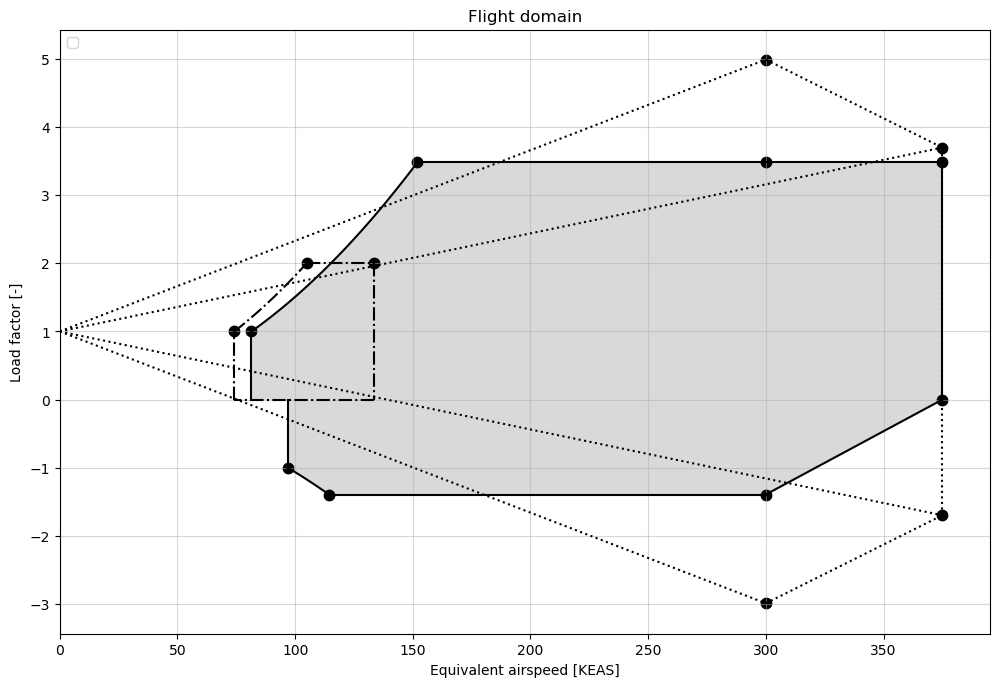

In [85]:
# Input here the number of aircraft you want to compare, the drawings and returning of the values will be different if this number is strictly greater than one
# to be able to plot information directly on the graph. Be careful to define as many instances of the Aircraft class as this number

aircraft_number = 1

# Define here the aircrafts which flight domain you want to compare. The syntax is always the same. The code will only work if the outputs of the 
# flight domain functions are called nameoftheoutput_nboftheaircraft for instance for the secod output of the first aircraft : load_factor_array_1

aircraft1 = Aircraft( mtow         = 1646.47    ,\
                      wing_area    = 16.953     ,\
                      mgc          = 16.953/11.9,\
                      Cl_alpha     = 7.0871     ,\
                      Cl_max       = 1.5372     ,\
                      Cl_max_flaps = 2.0011     ,\
                      Cl_min       = -1.0046    ,\
                      Cd_0         = 0.02607    ,\
                      k            = 0.0404     ,\
                      P_SL         = 231        ,\
                      eta_prop     = 0.85       ,\
                      Vh           = 200.0      ,\
                      level        = 2.0        ,\
                      cat          = 'normal'   ,\
                      Vh_known     = True       )

# aircraft2 = Aircraft( mtow         = 1646.18    ,\
#                       wing_area    = 10.951     ,\
#                       mgc          = 10.951/11.9,\
#                       Cl_alpha     = 5.0133     ,\
#                       Cl_max       = 1.5432     ,\
#                       Cl_max_flaps = 2.0432     ,\
#                       Cl_min       = -1.0046    ,\
#                       Cd_0         = 0.002541   ,\
#                       k            = 0.0378     ,\
#                       P_SL         = 231        ,\
#                       eta_prop     = 0.85       ,\
#                       Vh           = 0.0        ,\
#                       level        = 2.0        ,\
#                       cat          = 'normal'   ,\
#                       Vh_known     = False       )
# 
# aircraft3 = Aircraft( mtow         = 1646.18    ,\
#                       wing_area    = 16.951     ,\
#                       mgc          = 16.951/11.9,\
#                       Cl_alpha     = 5.0133     ,\
#                       Cl_max       = 1.5432     ,\
#                       Cl_max_flaps = 2.0432     ,\
#                       Cl_min       = -1.0046    ,\
#                       Cd_0         = 0.002541   ,\
#                       k            = 0.0378     ,\
#                       P_SL         = 231        ,\
#                       eta_prop     = 0.85       ,\
#                       Vh           = 0.0        ,\
#                       level        = 2.0        ,\
#                       cat          = 'normal'   ,\
#                       Vh_known     = False       )

# aircraft4 = Aircraft( mtow         = 1646.18    ,\
#                       wing_area    = 16.951     ,\
#                       mgc          = 13.951/11.9,\
#                       Cl_alpha     = 5.0133     ,\
#                       Cl_max       = 1.5432     ,\
#                       Cl_max_flaps = 1.8432     ,\
#                       Cl_min       = -1.0046    ,\
#                       Cd_0         = 0.002541   ,\
#                       k            = 0.0378     ,\
#                       P_SL         = 231        ,\
#                       eta_prop     = 0.85       ,\
#                       Vh           = 0.0        ,\
#                       level        = 2.0        ,\
#                       cat          = 'normal'   ,\
#                       Vh_known     = False       )

# This aircraft is very similar to the one presented in subchapter 16.4.1 of (1) 
# aircraft1 = Aircraft( mtow         = 600.00     ,\
#                       wing_area    = 12.077     ,\
#                       mgc          = 1.043      ,\
#                       Cl_alpha     = 5.25       ,\
#                       Cl_max       = 1.4        ,\
#                       Cl_max_flaps = 2.05       ,\
#                       Cl_min       = -1.00      ,\
#                       Cd_0         = 0.002541   ,\
#                       k            = 0.0378     ,\
#                       P_SL         = 231        ,\
#                       eta_prop     = 0.85       ,\
#                       Vh           = 120.0      ,\
#                       level        = 2.0        ,\
#                       cat          = 'normal'   ,\
#                       Vh_known     = True        )

# This aircraft is very similar to a Cirrus SR 22
# aircraft1 = Aircraft( mtow         = 1633.0     ,\
#                       wing_area    = 13.461     ,\
#                       mgc          = 1.228      ,\
#                       Cl_alpha     = 5.10       ,\
#                       Cl_max       = 1.41       ,\
#                       Cl_max_flaps = 1.99       ,\
#                       Cl_min       = -0.9       ,\
#                       Cd_0         = 0.002541   ,\
#                       k            = 0.0378     ,\
#                       P_SL         = 231        ,\
#                       eta_prop     = 0.85       ,\
#                       Vh           = 120.0      ,\
#                       level        = 2.0        ,\
#                       cat          = 'normal'   ,\
#                       Vh_known     = False       )

# This aircraft is very similar to the one presented in (2)
# aircraft1 = Aircraft( mtow         = 7647.5674     ,\
#                       wing_area    = 26.570        ,\
#                       mgc          = 26.570/17.678 ,\
#                       Cl_alpha     = 7.00          ,\
#                       Cl_max       = 2.0           ,\
#                       Cl_max_flaps = 4.24          ,\
#                       Cl_min       = -0.75         ,\
#                       Cd_0         = 0.002541      ,\
#                       k            = 0.0378        ,\
#                       P_SL         = 231           ,\
#                       eta_prop     = 0.85          ,\
#                       Vh           = 238.89        ,\
#                       level        = 4.0           ,\
#                       cat          = 'commuter'    ,\
#                       Vh_known     = True           )

# This aircraft is very similar to the one presented in (3) which looks to be a typical aerobatic aircraft
# aircraft1 = Aircraft( mtow         = 2300.00       ,\
#                       wing_area    = 19.33         ,\
#                       mgc          = 19.330/11.632 ,\
#                       Cl_alpha     = 6.33          ,\
#                       Cl_max       = 2.0           ,\
#                       Cl_max_flaps = 2.5           ,\
#                       Cl_min       = -1.2          ,\
#                       Cd_0         = 0.002541      ,\
#                       k            = 0.0378        ,\
#                       P_SL         = 231           ,\
#                       eta_prop     = 0.85          ,\
#                       Vh           = 345.45        ,\
#                       level        = 2.0           ,\
#                       cat          = 'aerobatics'  ,\
#                       Vh_known     = True           )

# This aircraft's data were approximated to match the TBM900
aircraft1 = Aircraft( mtow         = 3354.00       ,\
                      wing_area    = 18.00         ,\
                      mgc          = 18.00/12.833  ,\
                      Cl_alpha     = 5.85          ,\
                      Cl_max       = 1.7           ,\
                      Cl_max_flaps = 2.05          ,\
                      Cl_min       = -1.2          ,\
                      Cd_0         = 0.002541      ,\
                      k            = 0.0378        ,\
                      P_SL         = 231           ,\
                      eta_prop     = 0.85          ,\
                      Vh           = 330.00        ,\
                      level        = 2.0           ,\
                      cat          = 'normal'  ,\
                      Vh_known     = True           )

# We can now compute the design airspeeds of the aircraft and the design load factor
velocity_array_1, load_factor_array_1, conditions_1 = \
    aircraft1.flight_domain(aircraft1.mtow, 0.0, 300., design_n_ps = 0.0, design_n_ng = 0.0)
# velocity_array_2, load_factor_array_2, conditions_2 = \
#     aircraft2.flight_domain(aircraft2.mtow, 0.0, 160., design_n_ps = 0.0, design_n_ng = 0.0)
# velocity_array_3, load_factor_array_3, conditions_3 = \
#     aircraft3.flight_domain(aircraft3.mtow, 0.0, 160.)
#velocity_array_4, load_factor_array_4, conditions_4 = \
#    aircraft4.flight_domain(aircraft4.mtow, 0.0, 160.)
#velocity_array_5, load_factor_array_5, conditions_5 = \
#    aircraft5.flight_domain(aircraft4.mtow, 0.0, 160.)
# Uncomment the two lines below if you want to try the example given by (1) in sub-chapter 16.4.1
#velocity_array_1, load_factor_array_1, conditions_1 = \
#    aircraft1.flight_domain(aircraft1.mtow, 0.0, 107.)

plt.figure(1, figsize=(12,8), dpi= 100)

# aircraft1.plot_combined_flight_domain(velocity_array_1, load_factor_array_1, conditions_1, 1., fill = True, flaps = True, flaps_fill = False)
#aircraft2.plot_combined_flight_domain(velocity_array_2, load_factor_array_2, conditions_2, 2., fill = True, flaps = True, flaps_fill = False)
#aircraft3.plot_combined_flight_domain(velocity_array_3, load_factor_array_3, conditions_3, 3., fill = True, flaps = True, flaps_fill = False)
#aircraft4.plot_combined_flight_domain(velocity_array_4, load_factor_array_4, conditions_4, 4., fill = True, flaps = True, flaps_fill = False)
#aircraft5.plot_combined_flight_domain(velocity_array_5, load_factor_array_5, conditions_5, 5., fill = True, flaps = True, flaps_fill = False)

aircraft1.plot_separated_flight_domain(velocity_array_1, load_factor_array_1, conditions_1, 1., fill = True, flaps = True, flaps_fill = False)

# No need to plot the legend if there is only one aircraft which flight domain we are plotting

aircraft_name_array = []
result_array_velocity = [[],[],[],[],[],[],[],[],[],[],[]]
result_array_load_factor = [[],[],[],[],[],[],[],[],[],[]]

for i in range(1, aircraft_number + 1):
    aircraft_name_array.append('Aircraft ' + str(i))

for j in range(len(velocity_array_1)):
    for i in range(1, aircraft_number + 1):
        if i == 1:
            if round(velocity_array_1[j], 2) < 10.:
                result_array_velocity[j].append('  ' + str(round(velocity_array_1[j], 2))+' ')
            elif round(velocity_array_1[j], 2) < 100.:
                result_array_velocity[j].append(' ' + str(round(velocity_array_1[j], 2)))
            else:
                if len(str(round(velocity_array_1[j], 2))) < 6.:
                    result_array_velocity[j].append(str(round(velocity_array_1[j], 2)) + '0')
                else:
                    result_array_velocity[j].append(str(round(velocity_array_1[j], 2)))
        if i == 2:
            if round(velocity_array_2[j], 2) < 10.:
                result_array_velocity[j].append('  ' + str(round(velocity_array_2[j], 2))+' ')
            elif round(velocity_array_2[j], 2) < 100.:
                result_array_velocity[j].append(' ' + str(round(velocity_array_2[j], 2)))
            else:
                if len(str(round(velocity_array_2[j], 2))) < 6.:
                    result_array_velocity[j].append(str(round(velocity_array_2[j], 2)) + '0')
                else:
                    result_array_velocity[j].append(str(round(velocity_array_2[j], 2)))
        if i == 3:
            if round(velocity_array_3[j], 2) < 10.:
                result_array_velocity[j].append('  ' + str(round(velocity_array_3[j], 2))+' ')
            elif round(velocity_array_3[j], 2) < 100.:
                result_array_velocity[j].append(' ' + str(round(velocity_array_3[j], 2)))
            else:
                if len(str(round(velocity_array_3[j], 2))) < 6.:
                    result_array_velocity[j].append(str(round(velocity_array_3[j], 2)) + '0')
                else:
                    result_array_velocity[j].append(str(round(velocity_array_3[j], 2)))
        if i == 4:
            if round(velocity_array_4[j], 2) < 10.:
                result_array_velocity[j].append('  ' + str(round(velocity_array_4[j], 2))+' ')
            elif round(velocity_array_4[j], 2) < 100.:
                result_array_velocity[j].append(' ' + str(round(velocity_array_4[j], 2)))
            else:
                if len(str(round(velocity_array_4[j], 2))) < 6.:
                    result_array_velocity[j].append(str(round(velocity_array_4[j], 2)) + '0')
                else:
                    result_array_velocity[j].append(str(round(velocity_array_4[j], 2)))
        if i == 5:
            if round(velocity_array_5[j], 2) < 10.:
                result_array_velocity[j].append('  ' + str(round(velocity_array_5[j], 2))+' ')
            elif round(velocity_array_5[j], 2) < 100.:
                result_array_velocity[j].append(' ' + str(round(velocity_array_5[j], 2)))
            else:
                if len(str(round(velocity_array_5[j], 2))) < 6.:
                    result_array_velocity[j].append(str(round(velocity_array_5[j], 2)) + '0')
                else:
                    result_array_velocity[j].append(str(round(velocity_array_5[j], 2)))

for j in range(len(load_factor_array_1)):
    for i in range(1, aircraft_number + 1):
        if i == 1:
            if round(load_factor_array_1[j], 2) < 0:
                result_array_load_factor[j].append(str(round(load_factor_array_1[j], 2)))
            else:
                if len(str(round(load_factor_array_1[j], 2))) < 4:
                    result_array_load_factor[j].append(' ' + str(round(load_factor_array_1[j], 2)) + '0')
                else:
                    result_array_load_factor[j].append(' ' + str(round(load_factor_array_1[j], 2)))
        if i == 2:
            if round(load_factor_array_2[j], 2) < 0:
                result_array_load_factor[j].append(str(round(load_factor_array_2[j], 2)))
            else:
                if len(str(round(load_factor_array_2[j], 2))) < 4:
                    result_array_load_factor[j].append(' ' + str(round(load_factor_array_2[j], 2)) + '0')
                else:
                    result_array_load_factor[j].append(' ' + str(round(load_factor_array_2[j], 2)))
        if i == 3:
            if round(load_factor_array_3[j], 2) < 0:
                result_array_load_factor[j].append(str(round(load_factor_array_3[j], 2)))
            else:
                if len(str(round(load_factor_array_3[j], 2))) < 4:
                    result_array_load_factor[j].append(' ' + str(round(load_factor_array_3[j], 2)) + '0')
                else:
                    result_array_load_factor[j].append(' ' + str(round(load_factor_array_3[j], 2)))
        if i == 4:
            if round(load_factor_array_4[j], 2) < 0:
                result_array_load_factor[j].append(str(round(load_factor_array_4[j], 2)))
            else:
                if len(str(round(load_factor_array_4[j], 2))) < 4:
                    result_array_load_factor[j].append(' ' + str(round(load_factor_array_4[j], 2)) + '0')
                else:
                    result_array_load_factor[j].append(' ' + str(round(load_factor_array_4[j], 2)))
        if i == 5:
            if round(load_factor_array_5[j], 2) < 0:
                result_array_load_factor[j].append(str(round(load_factor_array_5[j], 2)))
            else:
                if len(str(round(load_factor_array_5[j], 2))) < 4:
                    result_array_load_factor[j].append(' ' + str(round(load_factor_array_5[j], 2)) + '0')
                else:
                    result_array_load_factor[j].append(' ' + str(round(load_factor_array_5[j], 2)))


print 'Design airspeeds :'
print '' 
print '                                     ' + '     '.join(aircraft_name_array)
print 'Positive 1g stall speed              ' + ' KEAS    '.join(result_array_velocity[0]) + ' KEAS'
print 'Negative 1g stall speed              ' + ' KEAS    '.join(result_array_velocity[1]) + ' KEAS'
print 'Positive maneuvering speed           ' + ' KEAS    '.join(result_array_velocity[2]) + ' KEAS'
print 'Negative maneuvering speed           ' + ' KEAS    '.join(result_array_velocity[3]) + ' KEAS'
print 'Design crusing speed                 ' + ' KEAS    '.join(result_array_velocity[4]) + ' KEAS'
print 'Design diving speed                  ' + ' KEAS    '.join(result_array_velocity[5]) + ' KEAS'
print 'Never-exceed speed                   ' + ' KEAS    '.join(result_array_velocity[6]) + ' KEAS'
print 'Maximum structural crusing speed     ' + ' KEAS    '.join(result_array_velocity[7]) + ' KEAS'
print 'Maximum gust intensity speed         ' + ' KEAS    '.join(result_array_velocity[8]) + ' KEAS'
print 'Positive flaps extended stall speed  ' + ' KEAS    '.join(result_array_velocity[9]) + ' KEAS'
print 'Maximum flaps extended speed         ' + ' KEAS    '.join(result_array_velocity[10]) + ' KEAS'

print ''
print 'Design load factors :'
print ''
print '                                     ' + '     '.join(aircraft_name_array)
print 'Positive design load factor          ' + '          '.join(result_array_load_factor[0])
print 'Negative design load factor          ' + '          '.join(result_array_load_factor[1])
print 'Positive maneuvering load factor     ' + '          '.join(result_array_load_factor[2])
print 'Negative maneuvering load factor     ' + '          '.join(result_array_load_factor[3])
print 'Positive crusing load factor         ' + '          '.join(result_array_load_factor[4])
print 'Negative crusing load factor         ' + '          '.join(result_array_load_factor[5])
print 'Positive diving load factor          ' + '          '.join(result_array_load_factor[6])
print 'Negative diving load factor          ' + '          '.join(result_array_load_factor[7])
print 'Maximum gust intensity load factor   ' + '          '.join(result_array_load_factor[8])
print 'Flaps extended maximum load factor   ' + '          '.join(result_array_load_factor[9])

print ''
# Uncomment to vertical line at ech design speed, not robust yet     
# if aircraft_number == 1.0:
    
    
    # plt.annotate( str(round(velocity_array_1[0], 2)), ( velocity_array_1[0], 0.0 ), ( velocity_array_1[0] - 5.0, -0.2 ) )
    # plt.annotate( str(round(velocity_array_1[1], 2)), ( velocity_array_1[1], 0.0 ), ( velocity_array_1[1] - 5.0,  0.13 ) )
    # plt.plot( [velocity_array_1[2], velocity_array_1[2]], [load_factor_array_1[2], 0.0], ls = '--', color = 'black' )
    # plt.annotate( str(round(velocity_array_1[2], 2)), ( velocity_array_1[2], 0.0 ), ( velocity_array_1[2] - 5.0, -0.2 ) )
    # plt.plot( [velocity_array_1[3], velocity_array_1[3]], [load_factor_array_1[3], 0.0], ls = '--', color = 'black' )
    # plt.annotate( str(round(velocity_array_1[3], 2)), ( velocity_array_1[3], 0.0 ), ( velocity_array_1[3] - 5.0,  0.13 ) )
    # plt.plot( [velocity_array_1[4], velocity_array_1[4]], [load_factor_array_1[4], 0.15], ls = '--', color = 'black' )
    # plt.plot( [velocity_array_1[4], velocity_array_1[4]], [load_factor_array_1[5], -0.15], ls = '--', color = 'black' )
    # plt.annotate( str(round(velocity_array_1[4], 2)), ( velocity_array_1[4], 0.0 ), ( velocity_array_1[4] - 5.0,  -0.04 ) )
    # plt.annotate( str(round(velocity_array_1[5], 2)), ( velocity_array_1[5], 0.0 ), ( velocity_array_1[5] - 14.0,  -0.04 ) )

# We also implemented a way to draw a simplified flight domain based on fewer information but the same aircraft structure. The 
# functions calls required to launch them can be found underneath

#velocity_array, load_factor_array = aircraft1.simplified_flight_domain( design_Vc = 160. )
#aircraft1.plot_simplified_flight_domain( velocity_array, load_factor_array, 1.0, True)

# We also implemented a way to draw the flight domain based on a set of values, all speeds are in KEAS and all load
# factors have no unit

Vs_1g_ps =  46.30 # Positive 1g stall speed
Vs_1g_ng =  54.70 # Negative 1g stall speed
Va       =  94.16 # Positive maneuvering speed
Vg       =  67.50 # Negative maneuvering speed
Vc       = 107.00 # Cruising speed
Vd       = 150.00 # Diving maneuvering speed
Vb       =   0.0  # Maximum gust intensity velocity (for commuters)

velocity_array = [ Vs_1g_ps, Vs_1g_ng, Va, Vg, Vc, Vd, Vb ]

n_lim_ps =  3.8  # Positive design load factor
n_lim_ng = -1.52 # Negative design load factor
n_Va     =  4.22 # Potivie maneuvering load factor
n_Vg     = -1.52 # Negative maneuvering load factor
n_Vc_ps  =  4.60 # Positive cruising load factor
n_Vc_ng  = -2.60 # Negative cruising load factor
n_Vd_ps  =  3.8  # Positive diving load factor
n_Vd_ng  = -1.52 # Negative diving load factor
n_Vb     =  0.0  # Maximum gust intensity load factor (for commuters)

load_factor_array = [ n_lim_ps, n_lim_ng, n_Va, n_Vg, n_Vc_ps, n_Vc_ng, n_Vd_ps, n_Vd_ng, n_Vb]

#plot_flight_domain_from_data(velocity_array, load_factor_array, category = 'aerobatics', fill = True)

# For the example used in the explanation used in (1) 
# velocity_array = [ 46.30, 54.70, 94.16, 67.50, 107.00, 150., 0. ]
# load_factor_array = [ 3.8, -1.52, 4.22, -1.52, 4.60, -2.60, 3.8, -1.52, 0.0 ]
# plot_flight_domain_from_data(velocity_array, load_factor_array, category = 'normal', fill = True)

# An attempt to guess the flight domain based on limited intels of the POH of the SR22 
# velocity_array = [ 70.00, 80.00, 136.00, 98.63, 178.00, 223., 0. ]
# load_factor_array = [ 3.8, -1.52, 3.8, -1.52, 3.8, -1.9, 3.8, -1.52, 0.0 ]
# plot_flight_domain_from_data(velocity_array, load_factor_array, category = 'normal', fill = True)

plt.legend(loc = 'upper left')
plt.grid(alpha = 0.5)
plt.title('Flight domain')
plt.xlabel('Equivalent airspeed [KEAS]')
plt.ylabel('Load factor [-]')
plt.xlim(left = 0.0)

References :                                                                                                                                        
(1) Gudmundsson, Snorri. General aviation aircraft design: Applied Methods and Procedures. Butterworth-Heinemann, 2013.                     
(2) NASA DEP commuter concept, https://www.slideshare.net/JohnMacnamara8/dep-final-presentation-74839514                                        
(3) Example of construction of V-n Diagram, https://www.academia.edu/32960805/V_n_diagram                                   